<a href="https://colab.research.google.com/github/mhdelta/machineLearningUtp/blob/master/Proyecto_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto 1 : Regresión lineal
###Miguel Ángel Henao Pérez-1088335496



#Imports

In [0]:
import scipy.io
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.patches as mpatches
import pandas as pd
import random as rn
import pandas.io.formats.style

In [0]:
#@title
"#@title"
def highlight_greaterthan_1(s):
    out = ['background-color: white']*len(s)
    if s.r2 > 0.80:
        out = ['background-color: yellow']*len(s)
    if s.r2 > 0.95:
        out = ['background-color: green']*len(s)
    return out
def highlight_bayes(s):
    out = ['background-color: white']*len(s)
    if s["Error bayes"] < 30:
        out = ['background-color: yellow']*len(s)
    if s["Error bayes"] < 20:
        out = ['background-color: green']*len(s)
    return out

#Upload ejemplo_regresion.mat


In [39]:
! wget https://github.com/mhdelta/machineLearningUtp/blob/master/data/ejemplo_regresion.mat?raw=true
!mv ejemplo_regresion.mat\?raw\=true ejemplo_regresion.mat
mat = scipy.io.loadmat("ejemplo_regresion.mat")

--2019-09-05 14:29:43--  https://github.com/mhdelta/machineLearningUtp/blob/master/data/ejemplo_regresion.mat?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mhdelta/machineLearningUtp/raw/master/data/ejemplo_regresion.mat [following]
--2019-09-05 14:29:43--  https://github.com/mhdelta/machineLearningUtp/raw/master/data/ejemplo_regresion.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhdelta/machineLearningUtp/master/data/ejemplo_regresion.mat [following]
--2019-09-05 14:29:43--  https://raw.githubusercontent.com/mhdelta/machineLearningUtp/master/data/ejemplo_regresion.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com

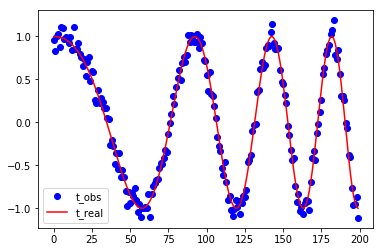

In [40]:
t_obs = mat["t"]
t_real = mat["y"]
x = mat["x"]
x = x.reshape(200,)
plt.plot(t_obs, "ob")
plt.plot(t_real, "-r")
plt.legend(("t_obs", "t_real"))

#Matriz de diseño y funciones base

In [0]:
# Matriz de diseño y funciones base

def fbasePoly(xtrain,M):
  auxPhiVect = np.zeros(M)
  indM = np.linspace(0,M-1,M)
  auxPhiVect = np.power(xtrain,indM)
  return auxPhiVect

def fbaseExp(xtrain,M):
  auxPhiVect = np.ones(M)
  mu = np.linspace(0,1,M-1)
  s2 = 0.01
  for i in range(1,M):
    auxPhiVect[i] = np.exp(-0.5*(1./s2)*(xtrain-mu[i-1])**2)
  return auxPhiVect

def fbaseSig(xtrain,M,mu = 1,s = 0.001):
    auxPhiVect = np.ones(M)
    for i in range(1,M):
        auxPhiVect[i] = sigma(xtrain)+0.3*np.random.randn(1)
    return auxPhiVect
def sigma(a):
    return 1/(1+np.exp(-a))

def desingMatrix(datos,M,fbase):
  auxMPHI = np.zeros((N,M))
  for n in range(0,N):
    auxMPHI[n,:] = fbase(datos[n],M)    
  return auxMPHI

#Funciones para estimación y obtención del modelo

In [0]:
def obtenerModelo(x,M,fbase):
    MPHI = desingMatrix(x,M,fbase)
    MPHIT = MPHI.T
    w_ml = np.linalg.inv(MPHIT.dot(MPHI)).dot(MPHIT.dot(t_obs))
    return MPHI, w_ml

def obtenerModeloRegulado(x,M,fbase, lam):
    MPHI = desingMatrix(x,M,fbase)
    MPHIT = MPHI.T
    w_ml_reg = np.linalg.inv(MPHIT@MPHI+lam*np.eye(M)).dot(MPHIT@t_obs)
    return MPHI, w_ml_reg
    
def graficar(x, t_real, t_obs, MPHI, yEst, func, M, error_mse, r2, color = 'ob'):
    fig = plt.figure(rn.randint(0, 1000))
    plts = plt.subplot()

    plts.plot(x,t_real,'-g')
    plts.plot(x,t_obs ,color)
    plts.plot(x,yEst ,'--k')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(('GT','t_obs','t_est'))
    fig.suptitle('Function: ' +  func + ' M: ' + str(m) + ' error mse: ' + str(error_mse[0]) + ' r2: ' + str(r2))

def estimarModelo(x,t_real,t_obs, MPHI, w_ml, cont, func, m, getr2):
    yEst = MPHI.dot(w_ml)
    error_mse = 0.5*(t_real-yEst).T.dot(t_real-yEst)
    r2 = 0
    if getr2:
        r2 = r2_score(t_real,yEst)
    return yEst, error_mse, r2

def logEvi(N, gamma, invSn, mn, MPHI, etiquetas, alpha, beta):
    levi = 0.5*N*np.log(alpha)+0.5*N*np.log(beta)
    E_mn = 0.5*beta*(etiquetas-MPHI.dot(mn)).dot(etiquetas-MPHI.dot(mn))+0.5*alpha*(mn.dot(mn))
    levi = levi - E_mn-0.5*np.log(np.linalg.det(invSn)) - 0.5*N*np.log(2*np.pi)
    return levi

def obtenerModeloBayesiano(x,M,fbase, max_iters=10):
    alpha = 100*np.random.randn(1)
    invBeta = 1 *np.random.randn(1)
    MPHI = desingMatrix(x,M,fbase)
    MPHIT = MPHI.T
    beta = 1/invBeta
    invSn = alpha*np.eye(M) + beta*MPHIT@MPHI
    Sn = np.linalg.inv(invSn) # covarianza del post
    mn = beta*(Sn.dot(MPHIT@t_obs)) # media del post
    errorBayes = np.zeros(max_iters)
    log_evi = np.zeros(max_iters)
    rho = np.linalg.eigvals(MPHIT@MPHI)
    for it in range(0,max_iters):
        lambda_i = beta*rho # todo el vector lambda
        gamma = np.sum(lambda_i/(lambda_i+alpha))
        alpha = gamma/(mn.dot(mn))
        invBeta = (1./(N-gamma))*(t_obs-MPHI.dot(mn)).dot(t_obs-MPHI.dot(mn))
        beta = 1/invBeta
        # Con alpha y beta puedo estimar los parámetros del posterior para w
        invSn = alpha*np.eye(M) + beta*MPHIT@MPHI
        #print(invSn)
        Sn = np.linalg.inv(invSn) # covarianza del post
        mn = beta*(Sn.dot(MPHIT@t_obs)) # media del post
        errorBayes[it] = 0.5*(t_obs-MPHI.dot(mn)).dot(t_obs-MPHI.dot(mn))
        log_evi[it] = logEvi(N, gamma, invSn, mn, MPHI, t_obs, alpha, beta)
    return MPHI, mn, errorBayes, alpha, beta

def graficarBayes(x, t_real, t_obs, MPHI, yEst, func, M, error_bayes, alpha, beta, color = 'ob'):
    fig = plt.figure(rn.randint(0, 1000))
    plts = plt.subplot()

    plts.plot(x,t_real,'-g')
    plts.plot(x,t_obs ,color)
    plts.plot(x,yEst ,'--k')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(('GT','t_obs','t_est'))
    fig.suptitle('Function: ' +  func + ' M: ' + str(m) + ' error bayes: ' + str(error_bayes[0]) + ' alpha: ' + str(alpha) + ' beta: ' + str(beta))

def printSdMean(info, F):
    for f in F:
        print('\033[94m' + f.__name__ + '\033[0m')
        print('\033[92m'+"Promedio"+'\033[0m')
        print(info[info["Función"] == f.__name__].mean())
        print('\033[92m'+"Desviación estandar"+'\033[0m')
        print(info[info["Función"] == f.__name__].std())
        print("----------------------------------------")

#Máxima verosimilitud

Modelo de máxima verosimilitud
fbaseExp
Promedio
E mse    398.979609
r2        -6.836171
dtype: float64
Desviación estandar
E mse    860.470879
r2        16.900104
dtype: float64
----------------------------------------
fbasePoly
Promedio
E mse    22.423428
r2        0.559592
dtype: float64
Desviación estandar
E mse    19.097883
r2        0.375093
dtype: float64
----------------------------------------
fbaseSig
Promedio
E mse    46.773370
r2        0.081346
dtype: float64
Desviación estandar
E mse    2.840182
r2       0.055783
dtype: float64
----------------------------------------


<Figure size 432x288 with 0 Axes>

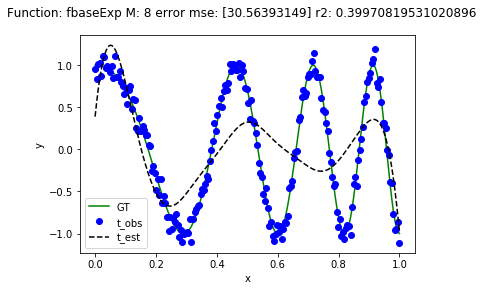

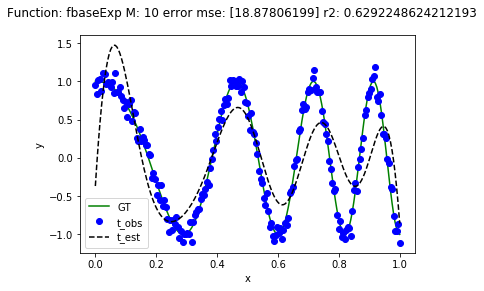

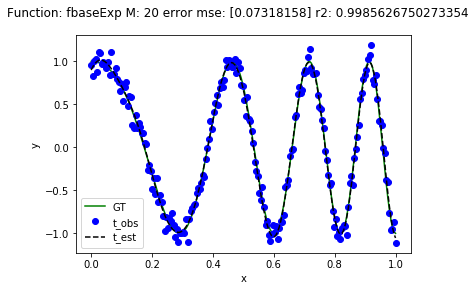

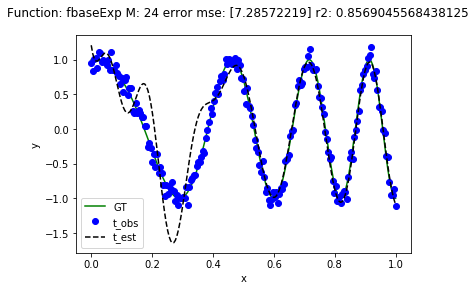

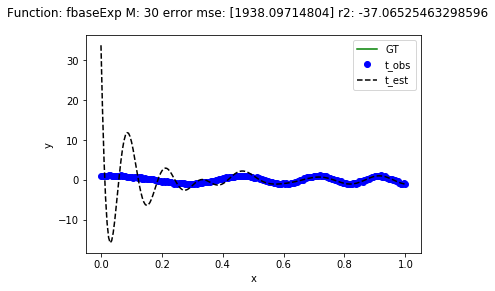

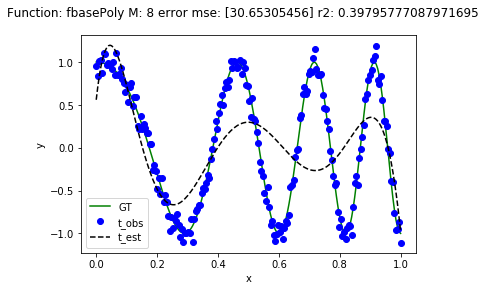

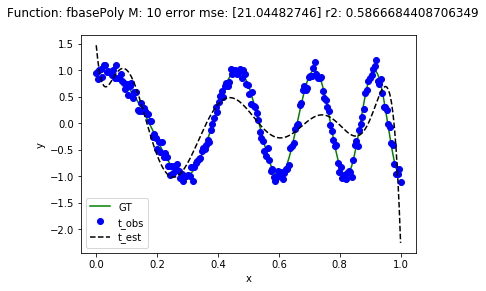

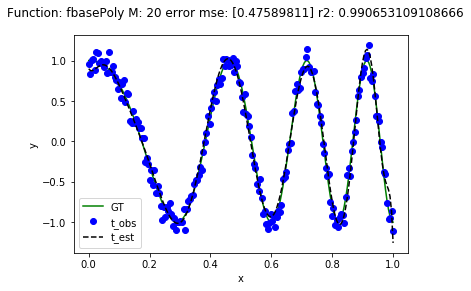

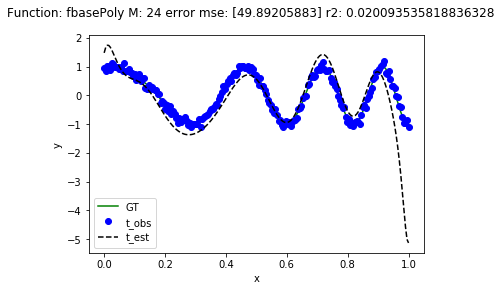

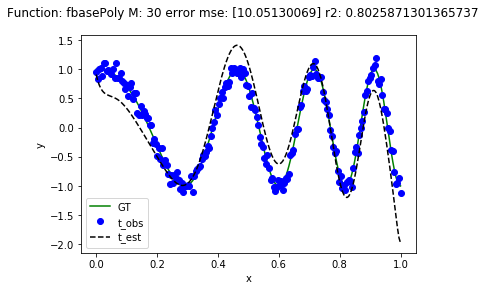

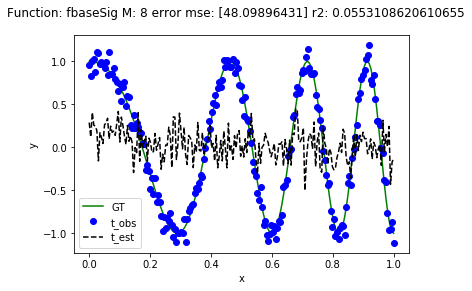

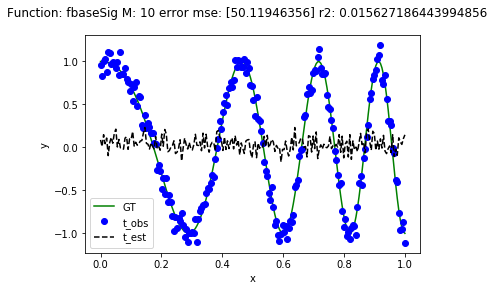

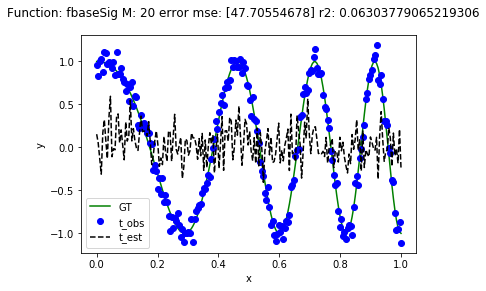

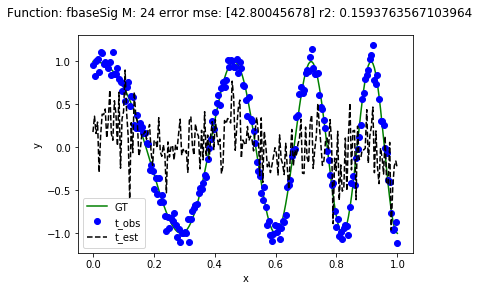

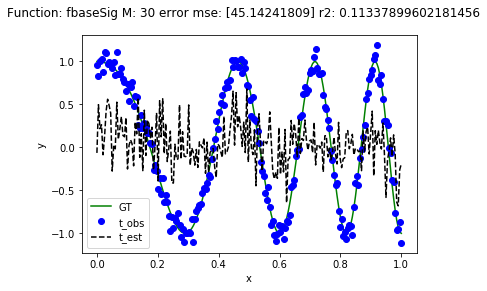

In [98]:
N = 200
M = [8, 10, 20, 24, 30] # Número de funciones base
F = [fbaseExp, fbasePoly, fbaseSig]
#Se encuentra el modelo w_ml y se prueba con cada función base, con 10, 20 y 30 funciones base
#Para cada una de ellas se muestra su gráfica y se reporta el error mse y la correlación
cont = 1
plt.figure(1)
columns = ["Función", "# F base", "E mse", "r2"]
infoMV = pd.DataFrame(columns = columns)
for f in F:
    for m in M:
        infoRow = []
        infoRow.append(f.__name__)
        infoRow.append(m)
        MPHI, w_ml = obtenerModelo(x, m, f)
        yEst, error_mse, r2 = estimarModelo(x, t_real, t_obs, MPHI, w_ml, cont, f.__name__, m, True)
        infoRow.append(error_mse[0][0])
        infoRow.append(r2)
        graficar(x, t_real, t_obs, MPHI, yEst, f.__name__, M, error_mse, r2)
        infoMV.loc[cont] = infoRow
        cont += 1

print("Modelo de máxima verosimilitud")
result = infoMV.sort_values(['Función','r2'])
result = result.style.apply(highlight_greaterthan_1, axis=1)
printSdMean(infoMV, F)
result



#Máxima verosimilitud con factor $\lambda$

In [0]:
def obtenerModeloRegulado(x,M,fbase, lam):
    MPHI = desingMatrix(x,M,fbase)
    MPHIT = MPHI.T
    w_ml_reg = np.linalg.inv(MPHIT@MPHI+lam*np.eye(M)).dot(MPHIT@t_obs)
    return MPHI, w_ml_reg

fbaseExp
Promedio
Lambda    0.050050
E mse     9.817115
r2        0.807187
dtype: float64
Desviación estandar
Lambda    0.054717
E mse     9.711576
r2        0.190740
dtype: float64
----------------------------------------
fbasePoly
Promedio
Lambda     0.05005
E mse     38.18687
r2         0.24999
dtype: float64
Desviación estandar
Lambda    0.054717
E mse     4.881160
r2        0.095869
dtype: float64
----------------------------------------
fbaseSig
Promedio
Lambda     0.050050
E mse     45.520868
r2         0.105946
dtype: float64
Desviación estandar
Lambda    0.054717
E mse     1.913300
r2        0.037578
dtype: float64
----------------------------------------


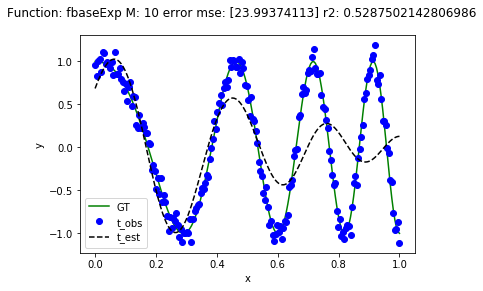

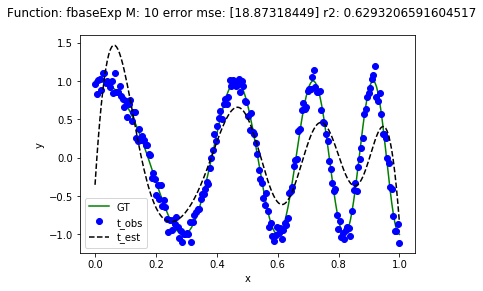

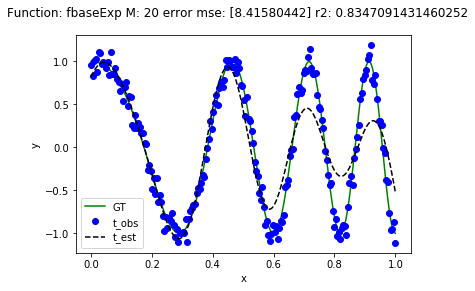

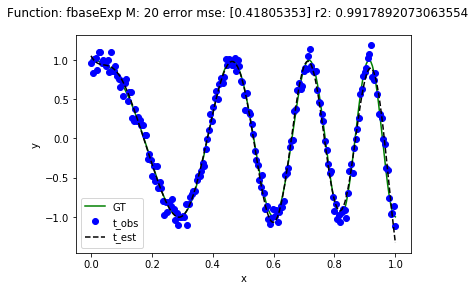

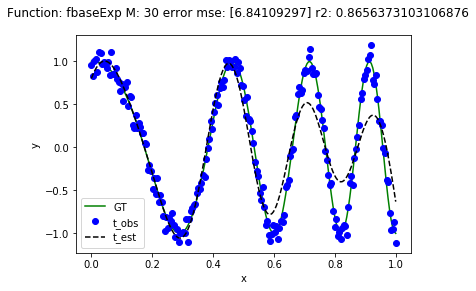

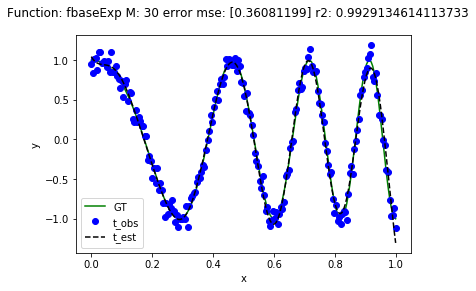

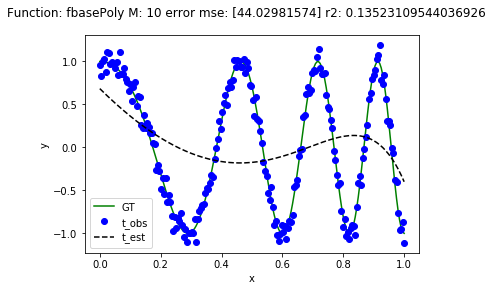

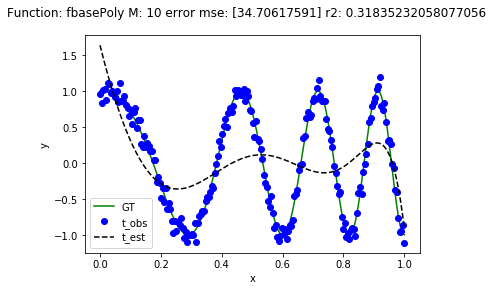

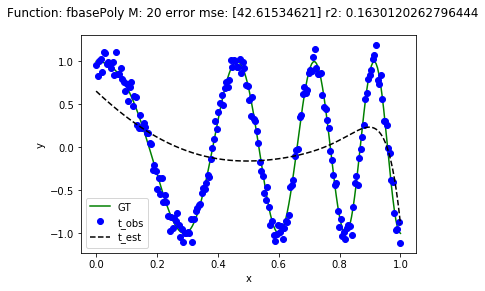

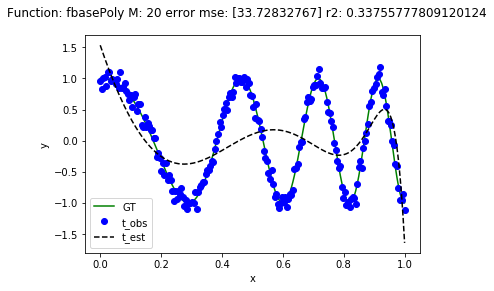

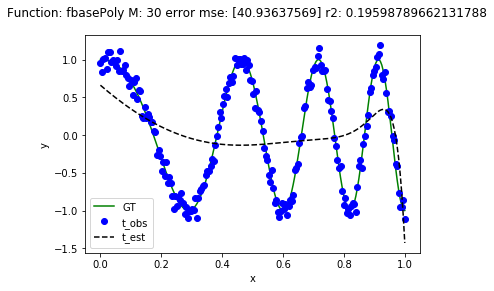

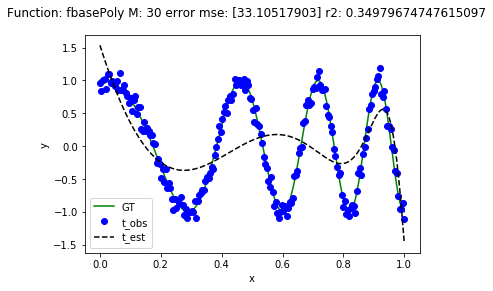

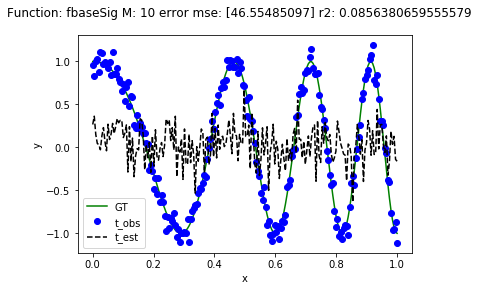

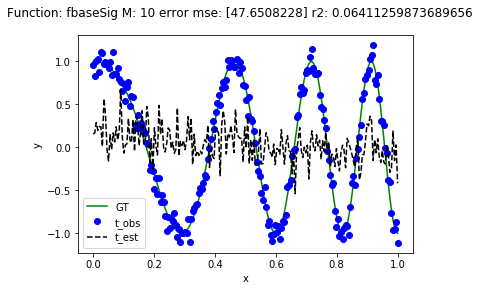

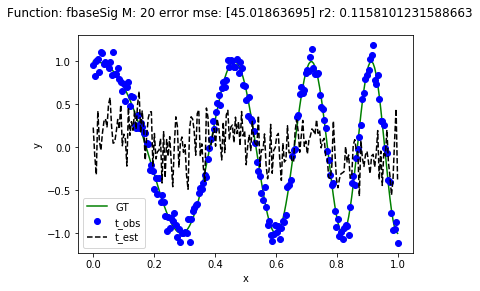

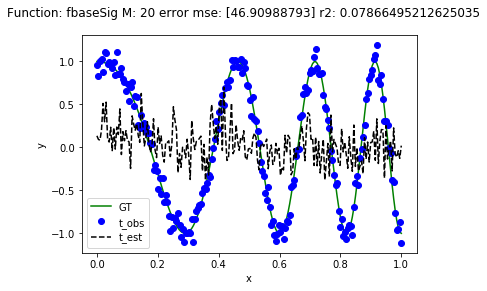

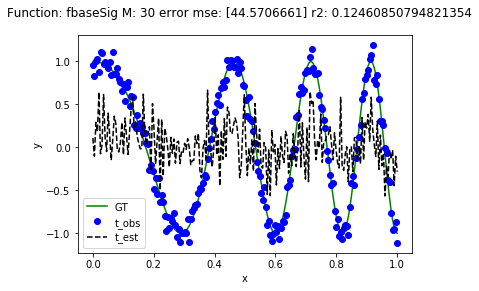

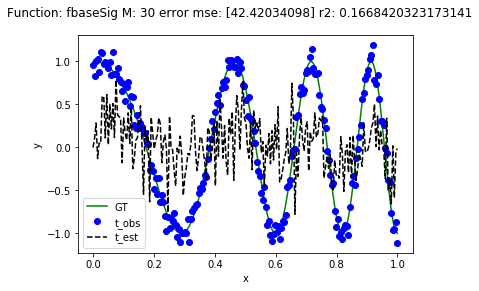

In [100]:
columns = ["Función", "# F base","Lambda", "E mse", "r2"]
infoRG = pd.DataFrame(columns = columns)
M = [10, 20, 30] # Número de funciones base
lambdas = [0.1, 0.0001]
for f in F:
    for m in M:
        for l in lambdas:
            infoRow = []
            infoRow.append(f.__name__)
            infoRow.append(m)
            infoRow.append(l)
            MPHI, w_ml = obtenerModeloRegulado(x, m, f, l)
            yEst, error_mse, r2 = estimarModelo(x, t_real, t_obs, MPHI, w_ml, cont, f.__name__, m, True)
            infoRow.append(error_mse[0][0])
            infoRow.append(r2)
            graficar(x, t_real, t_obs, MPHI, yEst, f.__name__, M, error_mse, r2)
            infoRG.loc[cont] = infoRow
            cont += 1

result = infoRG.sort_values('r2', ascending=0)
result = result.style.apply(highlight_greaterthan_1, axis=1)
printSdMean(infoRG, F)
result

#Regresión lineal Bayesiana

In [0]:
printSdMean(infoRG, F)
def logEvi(N, gamma, invSn, mn, MPHI, etiquetas, alpha, beta):
    levi = 0.5*N*np.log(alpha)+0.5*N*np.log(beta)
    E_mn = 0.5*beta*(etiquetas-MPHI.dot(mn)).dot(etiquetas-MPHI.dot(mn))+0.5*alpha*(mn.dot(mn))
    levi = levi - E_mn-0.5*np.log(np.linalg.det(invSn)) - 0.5*N*np.log(2*np.pi)
    return levi

def obtenerModeloBayesiano(x,M,fbase, max_iters=10):
    alpha = 100*np.random.randn(1)
    invBeta = 1 *np.random.randn(1)
    MPHI = desingMatrix(x,M,fbase)
    MPHIT = MPHI.T
    beta = 1/invBeta
    invSn = alpha*np.eye(M) + beta*MPHIT@MPHI
    Sn = np.linalg.inv(invSn) # covarianza del post
    mn = beta*(Sn.dot(MPHIT@t_obs)) # media del post
    errorBayes = np.zeros(max_iters)
    log_evi = np.zeros(max_iters)
    rho = np.linalg.eigvals(MPHIT@MPHI)
    for it in range(0,max_iters):
        lambda_i = beta*rho # todo el vector lambda
        gamma = np.sum(lambda_i/(lambda_i+alpha))
        alpha = gamma/(mn.dot(mn))
        invBeta = (1./(N-gamma))*(t_obs-MPHI.dot(mn)).dot(t_obs-MPHI.dot(mn))
        beta = 1/invBeta
        # Con alpha y beta puedo estimar los parámetros del posterior para w
        invSn = alpha*np.eye(M) + beta*MPHIT@MPHI
        #print(invSn)
        Sn = np.linalg.inv(invSn) # covarianza del post
        mn = beta*(Sn.dot(MPHIT@t_obs)) # media del post
        errorBayes[it] = 0.5*(t_obs-MPHI.dot(mn)).dot(t_obs-MPHI.dot(mn))
        log_evi[it] = logEvi(N, gamma, invSn, mn, MPHI, t_obs, alpha, beta)
    return MPHI, mn, errorBayes, alpha, beta

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


fbaseExp
Promedio
Error bayes      (25.35790729176559+0j)
alpha          (0.21836719802660934+0j)
beta             (68.54789917377073+0j)
dtype: complex128
Desviación estandar
Error bayes     5.043530
alpha           0.374687
beta           56.081884
dtype: float64
----------------------------------------
fbasePoly
Promedio
Error bayes     (49.03586130128255+0j)
alpha           (955.9269153284364+0j)
beta           (2.1301112901678874+0j)
dtype: complex128
Desviación estandar
Error bayes       2.651393
alpha          1655.071152
beta              0.224153
dtype: float64
----------------------------------------
fbaseSig
Promedio
Error bayes     (56.19880484295143+0j)
alpha           (838432.7517641365+0j)
beta           (1.9044925472538234+0j)
dtype: complex128
Desviación estandar
Error bayes    9.612587e+00
alpha          1.335074e+06
beta           1.778754e-03
dtype: float64
----------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


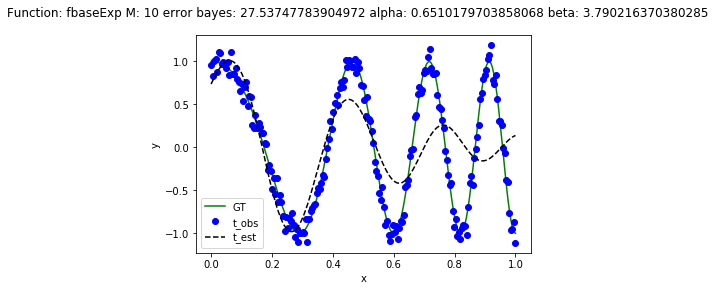

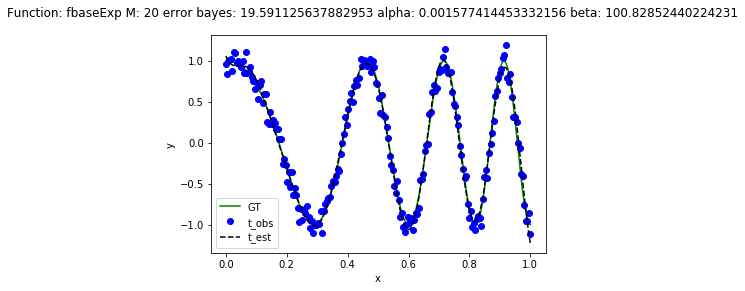

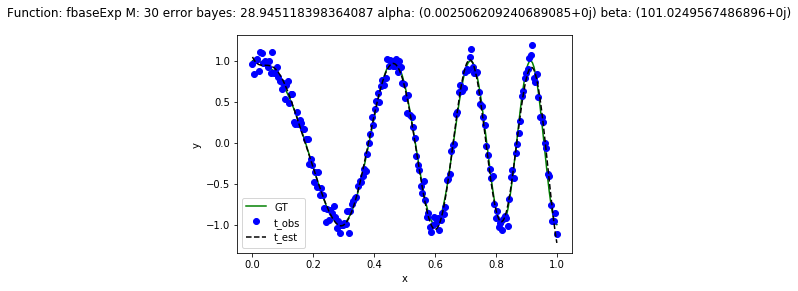

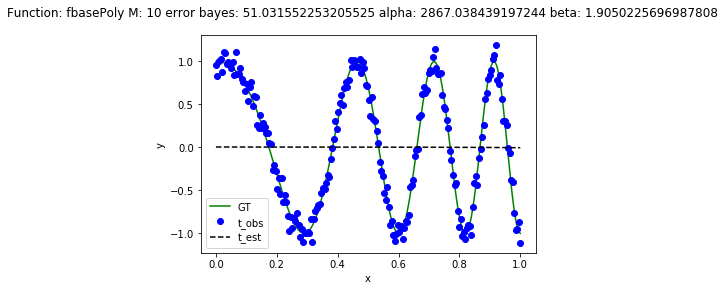

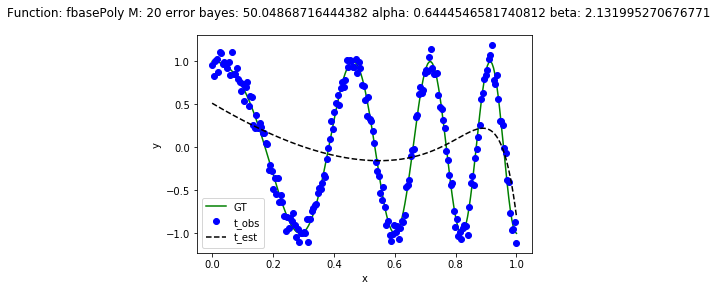

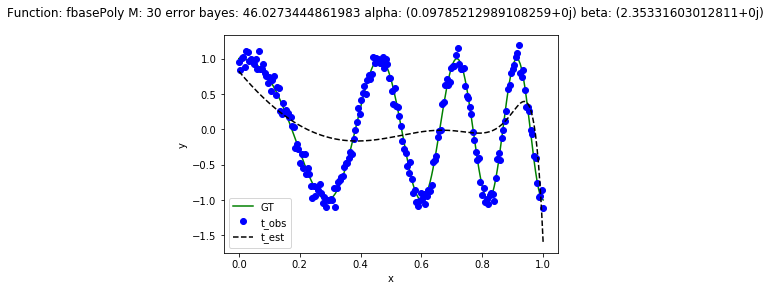

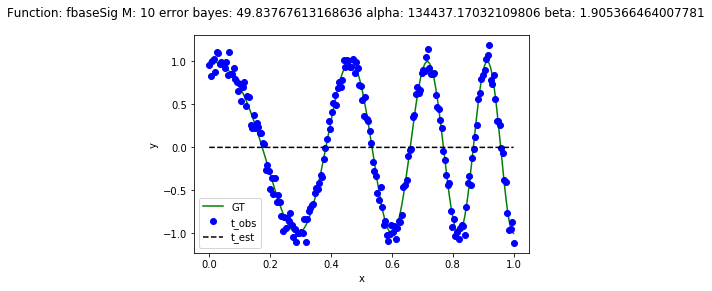

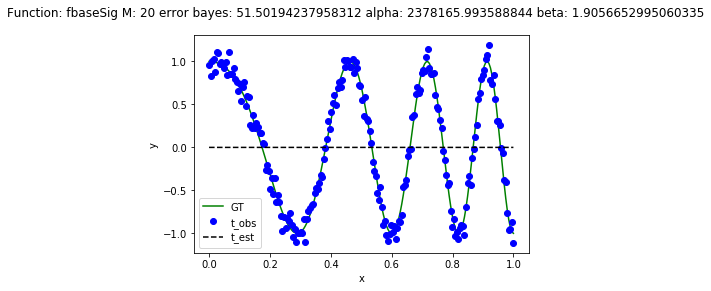

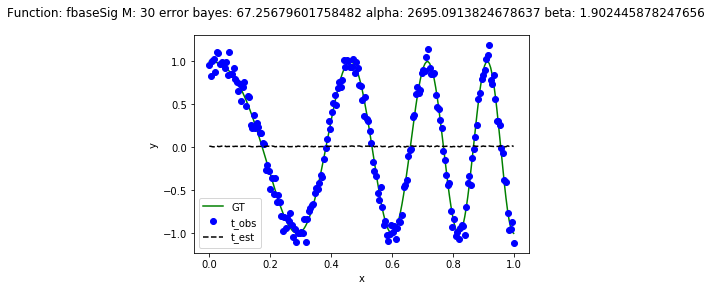

In [101]:
columns = ["Función", "# F base","Error bayes", "alpha", "beta"]
infoBY = pd.DataFrame(columns = columns)
M = [10, 20, 30] # Número de funciones base
a = 0
b = 0
x = x.reshape((200,))
x = x.reshape((200,))
t_obs = t_obs.reshape((200,))
t_real = t_real.reshape((200,))
for f in F:
    for m in M:
        infoRow = []
        infoRow.append(f.__name__)
        infoRow.append(m)
        MPHI, mn, error_bayes, a, b = obtenerModeloBayesiano(x, m, f, 10)
        yEst, error_mse, r2 = estimarModelo(x, t_real, t_obs, MPHI, mn, cont, f.__name__, m, getr2=False)
        infoRow.append(error_bayes[0])
        infoRow.append(a)
        infoRow.append(b)
        # infoRow.append(r2)
        graficarBayes(x, t_real, t_obs, MPHI, yEst, f.__name__, M, error_bayes, a, b)
        infoBY.loc[cont] = infoRow
        cont += 1

result = infoBY.sort_values('Error bayes', ascending=0)
result = result.style.apply(highlight_bayes, axis=1)
printSdMean(infoBY, F)
result

#ConsumoDB


## Upload - **señal consumo promedio** ConsumoDB.mat

In [102]:
! wget https://github.com/mhdelta/machineLearningUtp/blob/master/data/consumoDB.mat?raw=true
!mv consumoDB.mat\?raw\=true consumoDB.mat
mat = scipy.io.loadmat("consumoDB.mat")

--2019-09-05 15:24:02--  https://github.com/mhdelta/machineLearningUtp/blob/master/data/consumoDB.mat?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mhdelta/machineLearningUtp/raw/master/data/consumoDB.mat [following]
--2019-09-05 15:24:03--  https://github.com/mhdelta/machineLearningUtp/raw/master/data/consumoDB.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhdelta/machineLearningUtp/master/data/consumoDB.mat [following]
--2019-09-05 15:24:03--  https://raw.githubusercontent.com/mhdelta/machineLearningUtp/master/data/consumoDB.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.1

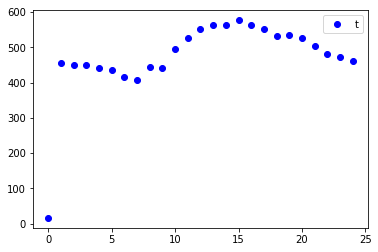

In [103]:
t_obs = mat["t"]
x = mat["x"]
plt.plot(t_obs, "ob")
plt.legend(("t_obs"))

## Funciones para consumoDB

In [0]:
def estimarModeloConsumo(x,t_real,t_obs, MPHI, w_ml, cont, func, m, getr2):
    yEst = MPHI.dot(w_ml)
    error_mse=100
    if t_real.shape == yEst.shape:
        error_mse = 0.5*(t_real-yEst).T.dot(t_real-yEst)
    r2 = 0
    if getr2:
        r2 = r2_score(t_real,yEst)
    return yEst, error_mse, r2

def graficarConsumoReg(x, t_real, t_obs, MPHI, yEst, func, M, error_mse, r2, l, color = 'or'):
    fig = plt.figure(rn.randint(0, 1000))
    plts = plt.subplot()

    plts.plot(x,t_obs ,color)
    plts.plot(x,yEst ,'--k')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(('t_obs','t_est'))
    fig.suptitle('Function: ' +  func + ' M: ' + str(m) + ' error mse: ' + str(error_mse[0]) + ' r2: ' + str(r2) + ' Lambda: '+ str(l))


## Máxima verosimilitud - consumoDB

Modelo de máxima verosimilitud
fbaseExp
Promedio
E mse    7.882670e+06
r2      -5.437466e+01
dtype: float64
Desviación estandar
E mse    7.512999e+06
r2       5.277778e+01
dtype: float64
----------------------------------------
fbasePoly
Promedio
E mse    1.096830e+12
r2      -7.705079e+06
dtype: float64
Desviación estandar
E mse    1.697246e+12
r2       1.192291e+07
dtype: float64
----------------------------------------
fbaseSig
Promedio
E mse    2.810278e+07
r2      -1.964181e+02
dtype: float64
Desviación estandar
E mse    4.860995e+07
r2       3.414781e+02
dtype: float64
----------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


<Figure size 432x288 with 0 Axes>

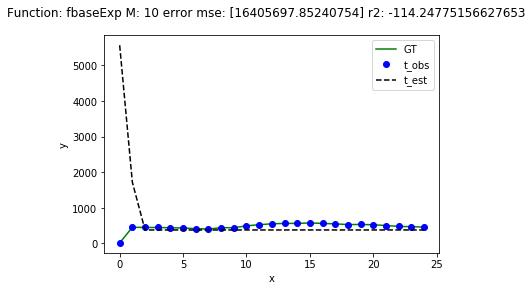

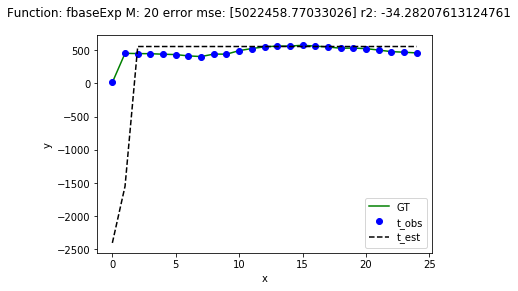

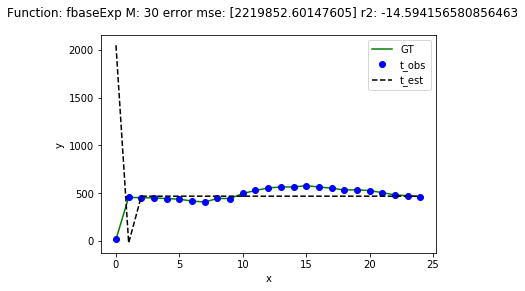

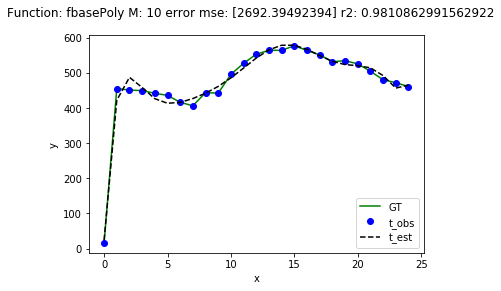

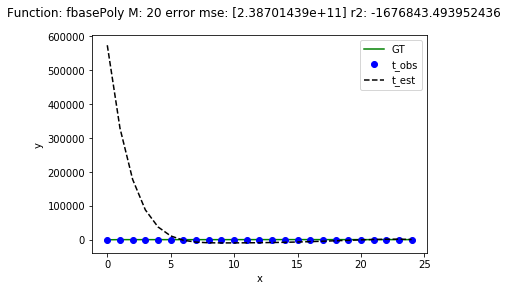

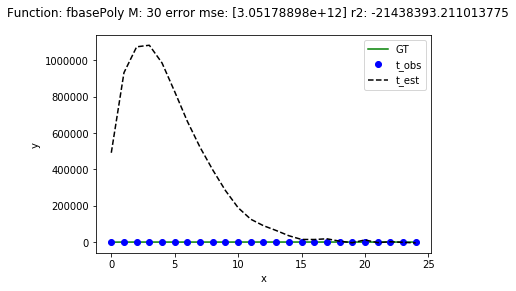

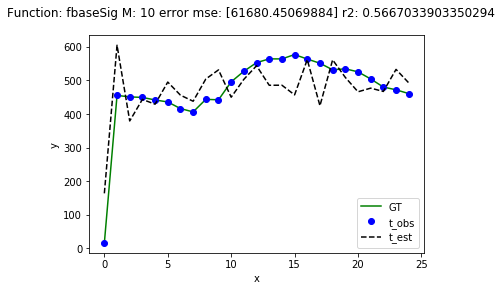

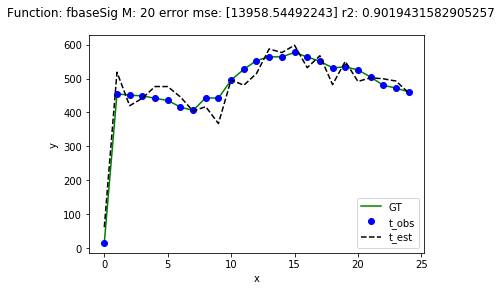

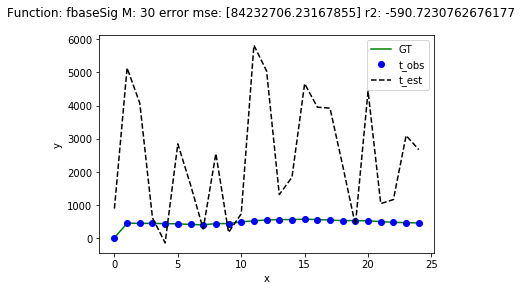

In [105]:
N = 25
M = [10, 20, 30] # Número de funciones base
F = [fbaseExp, fbasePoly, fbaseSig]
cont = 1
plt.figure(1)
columns = ["Función", "# F base", "E mse", "r2"]
infoMVConsumo = pd.DataFrame(columns = columns)
t_real = t_obs
for f in F:
    for m in M:
        infoRow = []
        infoRow.append(f.__name__)
        infoRow.append(m)
        MPHI, w_ml = obtenerModelo(x, m, f)
        yEst, error_mse, r2 = estimarModeloConsumo(x, t_real, t_obs, MPHI, w_ml, cont, f.__name__, m, True)
        infoRow.append(error_mse[0][0])
        infoRow.append(r2)
        graficar(x, t_real, t_obs, MPHI, yEst, f.__name__, M, error_mse, r2)
        infoMVConsumo.loc[cont] = infoRow
        cont += 1
print("Modelo de máxima verosimilitud")
result = infoMVConsumo.sort_values('r2', ascending=0)
result = result.style.apply(highlight_greaterthan_1, axis=1)
printSdMean(infoMVConsumo, F)
result

## Máxima verosimilitud con regularización $\lambda$ - ConsumoDB

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


Modelo de máxima verosimilitud con regularizacion, consumodb
fbaseExp
Promedio
lambda        0.100005
E mse     32946.701028
r2            0.768554
dtype: float64
Desviación estandar
lambda       0.109539
E mse     1133.938022
r2           0.007966
dtype: float64
----------------------------------------
fbasePoly
Promedio
lambda    1.000050e-01
E mse     4.343270e+13
r2       -3.051087e+08
dtype: float64
Desviación estandar
lambda    1.095390e-01
E mse     9.790015e+13
r2        6.877350e+08
dtype: float64
----------------------------------------
fbaseSig
Promedio
lambda        0.100005
E mse     31223.085841
r2            0.780662
dtype: float64
Desviación estandar
lambda        0.109539
E mse     35220.044389
r2            0.247416
dtype: float64
----------------------------------------


<Figure size 432x288 with 0 Axes>

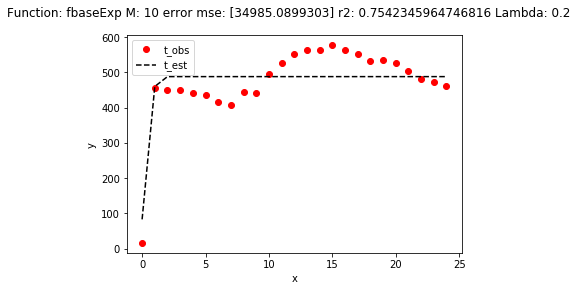

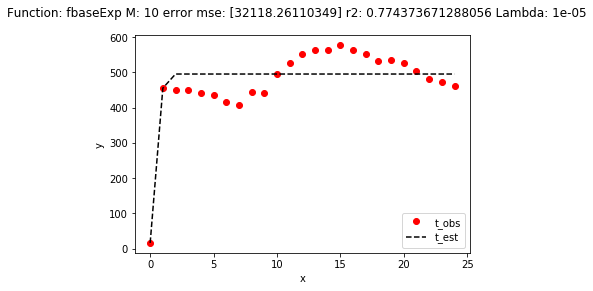

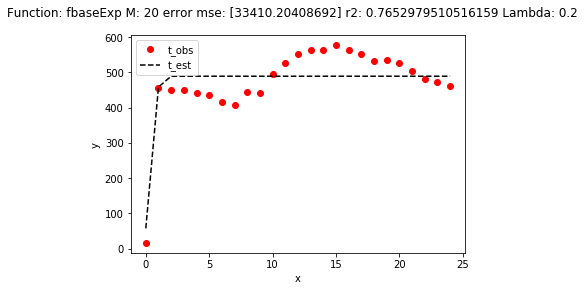

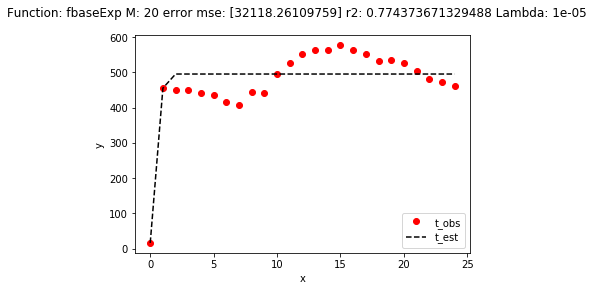

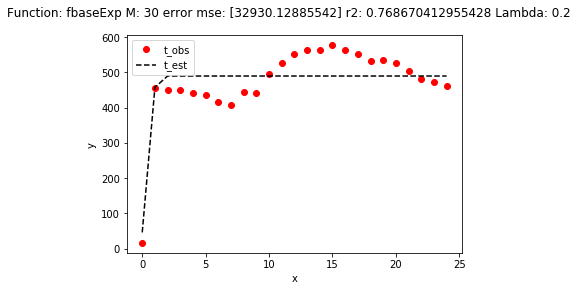

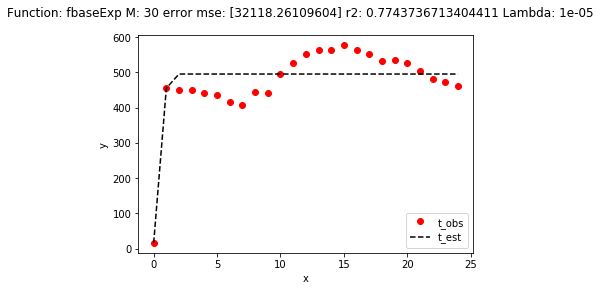

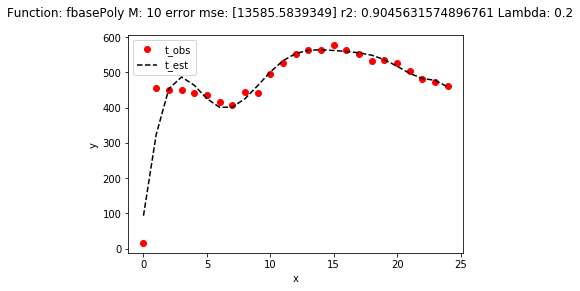

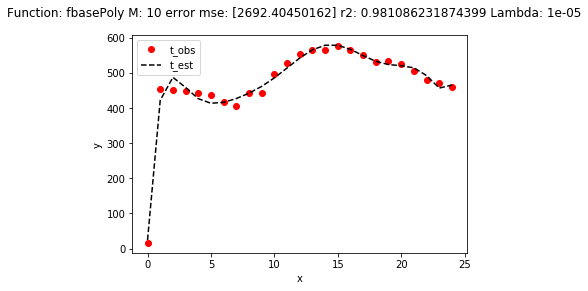

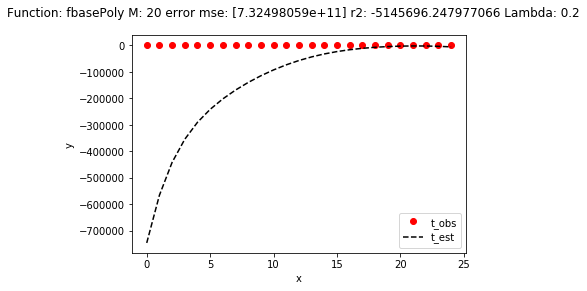

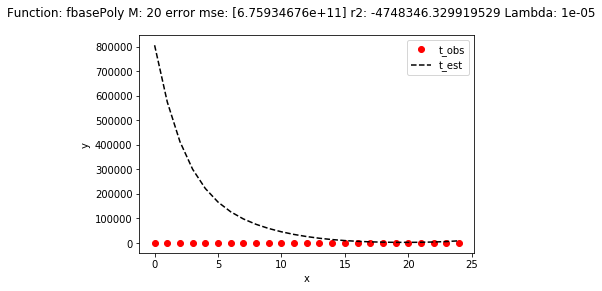

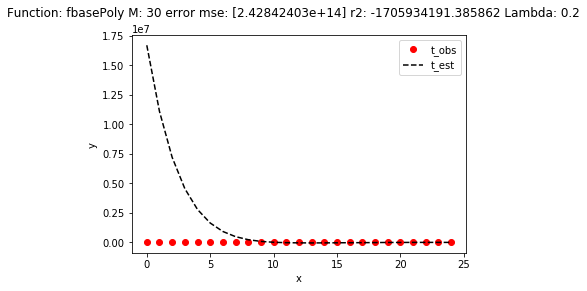

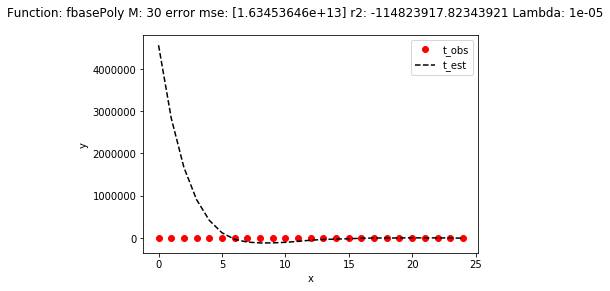

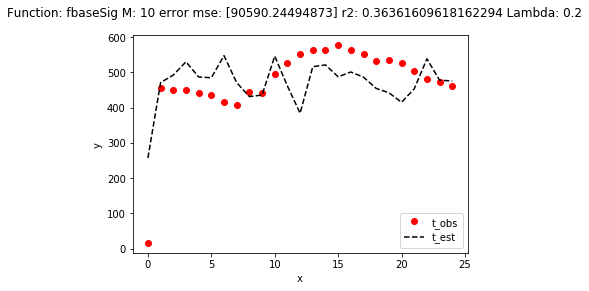

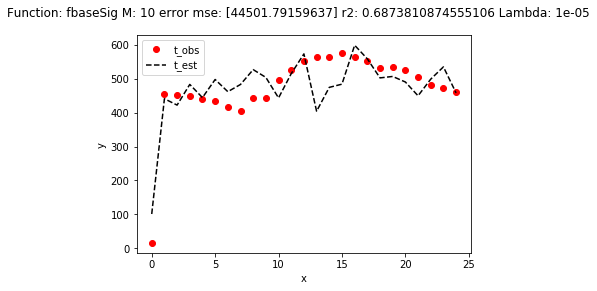

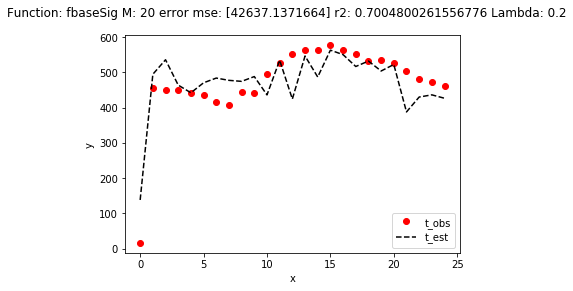

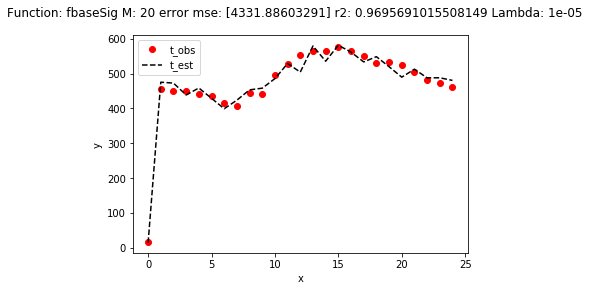

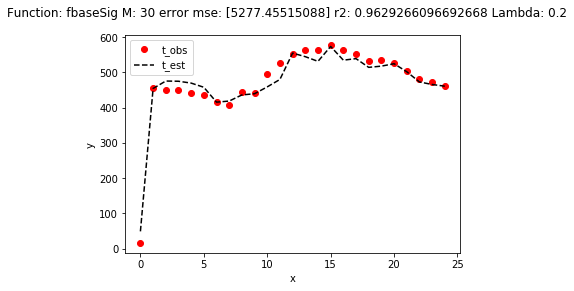

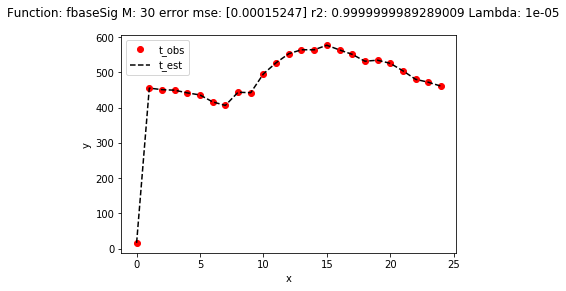

In [106]:
N = 25
M = [10, 20, 30] # Número de funciones base
F = [fbaseExp, fbasePoly, fbaseSig]
cont = 1
plt.figure(1)
columns = ["Función", "# F base", "lambda", "E mse", "r2"]
infoMVConsumoReg = pd.DataFrame(columns = columns)
t_real = t_obs
lambdas = [0.2, 0.00001]
for f in F:
    for m in M:
        for l in lambdas:
            infoRow = []
            infoRow.append(f.__name__)
            infoRow.append(m)
            infoRow.append(l)
            MPHI, w_ml = obtenerModeloRegulado(x, m, f, l)
            yEst, error_mse, r2 = estimarModeloConsumo(x, t_real, t_obs, MPHI, w_ml, cont, f.__name__, m, True)
            infoRow.append(error_mse[0][0])
            infoRow.append(r2)
            graficarConsumoReg(x, t_real, t_obs, MPHI, yEst, f.__name__, M, error_mse, r2, l)
            infoMVConsumoReg.loc[cont] = infoRow
            cont += 1
print("Modelo de máxima verosimilitud con regularizacion, consumodb")
result = infoMVConsumoReg.sort_values('r2', ascending=0)
result = result.style.apply(highlight_greaterthan_1, axis=1)
printSdMean(infoMVConsumoReg, F)
result

## Regresión lineal bayeasiana - consumoDB

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


fbaseExp
Promedio
Error bayes                            (34874.66945848032+0j)
alpha          (8.227525793928617e-06-1.182268529983573e-38j)
beta           (0.0003426252232530066+6.469839835172238e-38j)
dtype: complex128
Desviación estandar
Error bayes    3.511456e+03
alpha          1.207793e-06
beta           8.797715e-09
dtype: float64
----------------------------------------
fbasePoly
Promedio
Error bayes        (153758290230918.1+0j)
alpha             (1220.2541653206672+0j)
beta           (5.748961886169964e-06+0j)
dtype: complex128
Desviación estandar
Error bayes    2.663149e+14
alpha          2.113542e+03
beta           9.955138e-06
dtype: float64
----------------------------------------
fbaseSig
Promedio
Error bayes         (6404794.463361006+0j)
alpha          (4.9181219172187766e-05+0j)
beta           (0.00038760106570891477+0j)
dtype: complex128
Desviación estandar
Error bayes    1.078377e+07
alpha          1.941384e-05
beta           2.275957e-04
dtype: float64
-----------

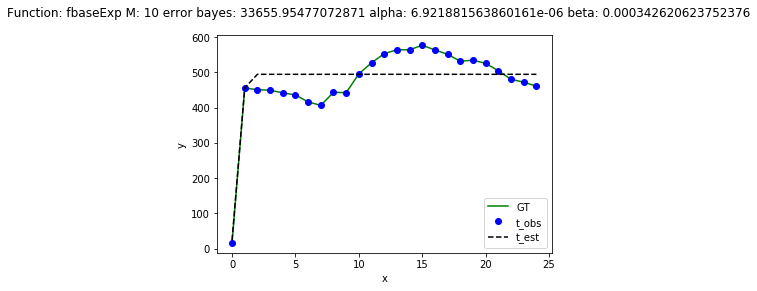

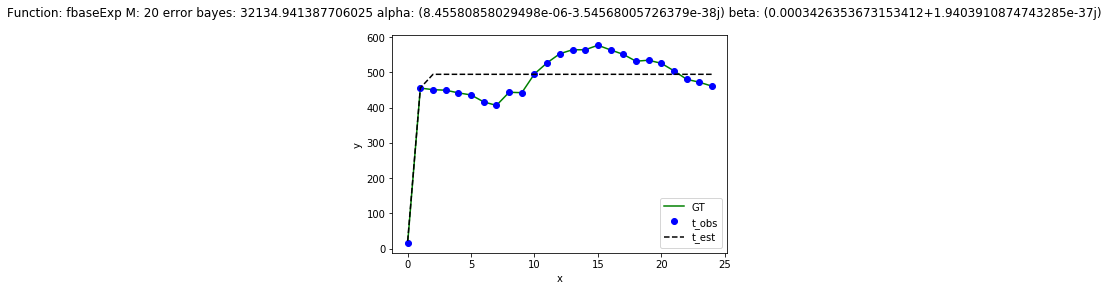

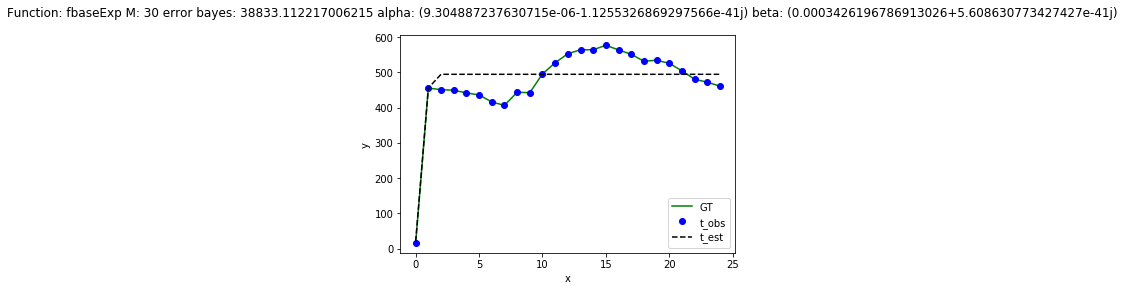

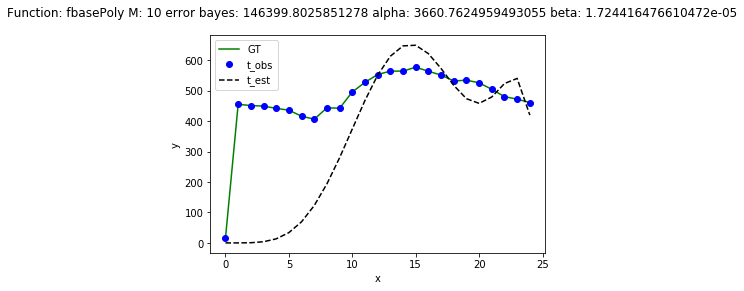

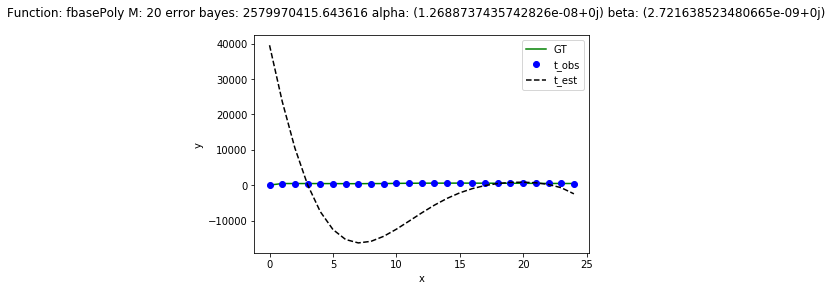

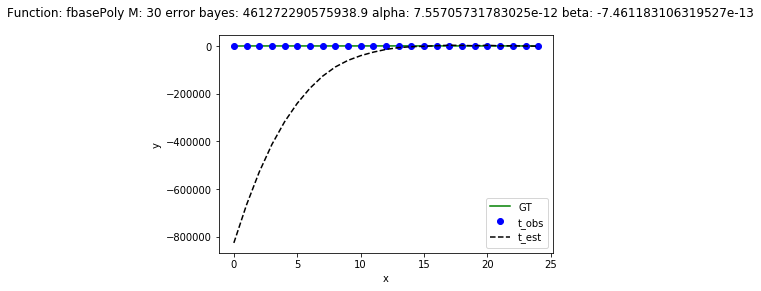

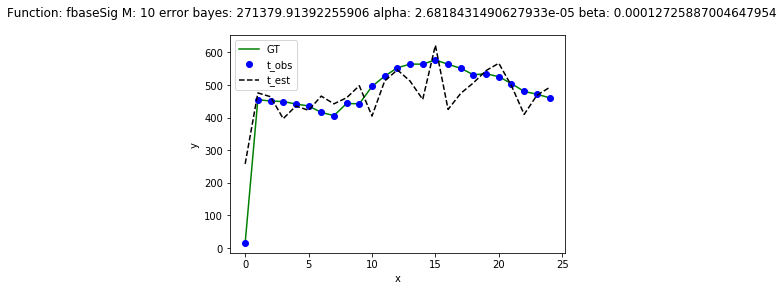

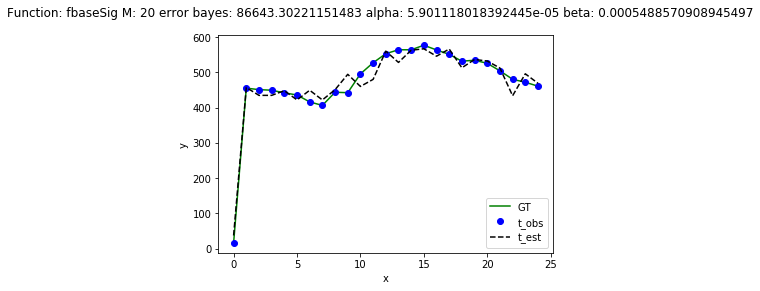

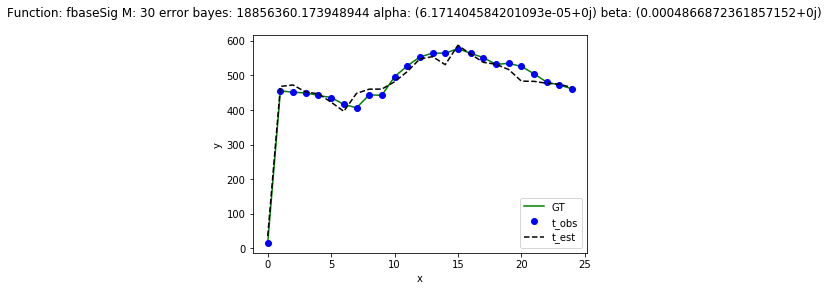

In [107]:
x = x.reshape(25,)
t_obs = t_obs.reshape(25,)
columns = ["Función", "# F base","Error bayes", "alpha", "beta"]
infoBYConsumo = pd.DataFrame(columns = columns)
M = [10, 20, 30] # Número de funciones base
a = 0
b = 0
t_real = t_obs
for f in F:
    for m in M:
        infoRow = []
        infoRow.append(f.__name__)
        infoRow.append(m)
        MPHI, mn, error_bayes, a, b = obtenerModeloBayesiano(x, m, f, 15)
        yEst, error_mse, r2 = estimarModelo(x, t_real, t_obs, MPHI, mn, cont, f.__name__, m, getr2=False)
        infoRow.append(error_bayes[0])
        infoRow.append(a)
        infoRow.append(b)
        # infoRow.append(r2)
        graficarBayes(x, t_real, t_obs, MPHI, yEst, f.__name__, M, error_bayes, a, b)
        infoBYConsumo.loc[cont] = infoRow
        cont += 1

result = infoBYConsumo.sort_values('Error bayes', ascending=0)
result = result.style.apply(highlight_bayes, axis=1)
printSdMean(infoBYConsumo, F)
result

#Respiration.mat

## upload Variación en la respiración

In [108]:
! wget https://github.com/mhdelta/machineLearningUtp/blob/master/data/respiration.mat?raw=true
!mv respiration.mat\?raw\=true respiration.mat

--2019-09-05 15:27:58--  https://github.com/mhdelta/machineLearningUtp/blob/master/data/respiration.mat?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mhdelta/machineLearningUtp/raw/master/data/respiration.mat [following]
--2019-09-05 15:27:59--  https://github.com/mhdelta/machineLearningUtp/raw/master/data/respiration.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhdelta/machineLearningUtp/master/data/respiration.mat [following]
--2019-09-05 15:27:59--  https://raw.githubusercontent.com/mhdelta/machineLearningUtp/master/data/respiration.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.1

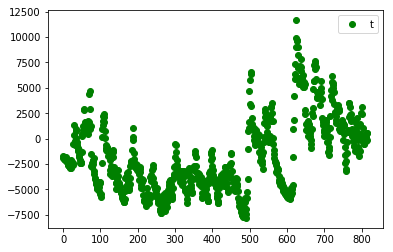

In [109]:
mat = scipy.io.loadmat("respiration.mat")
t_obs = mat["t"]
x = mat["x"]
plt.plot(t_obs, "og")
plt.legend(("t_obs"))

## Máxima verosimilitud - respiration.mat

Modelo de máxima verosimilitud
fbaseExp
Promedio
r2   -39.581467
dtype: float64
Desviación estandar
r2    68.554863
dtype: float64
----------------------------------------
fbasePoly
Promedio
r2   -1885.897314
dtype: float64
Desviación estandar
r2    3251.132551
dtype: float64
----------------------------------------
fbaseSig
Promedio
r2    0.021504
dtype: float64
Desviación estandar
r2    0.013745
dtype: float64
----------------------------------------


<Figure size 432x288 with 0 Axes>

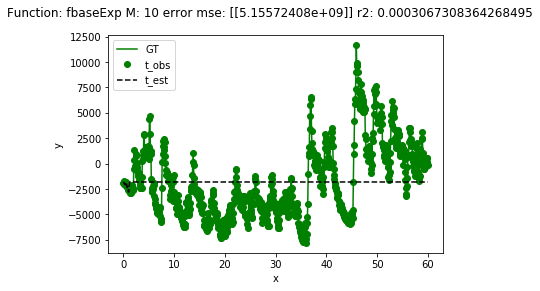

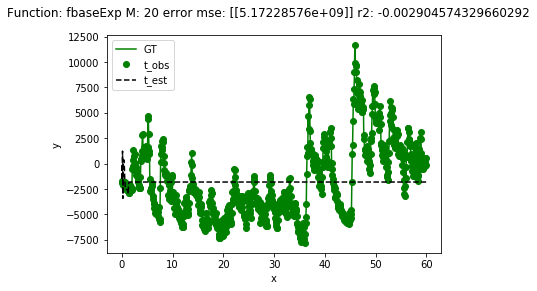

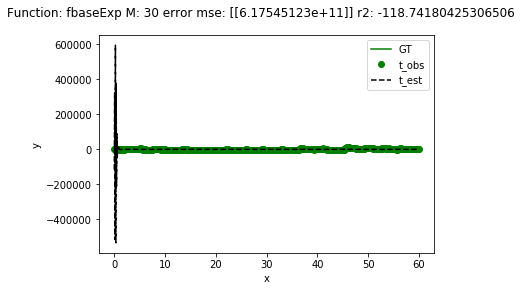

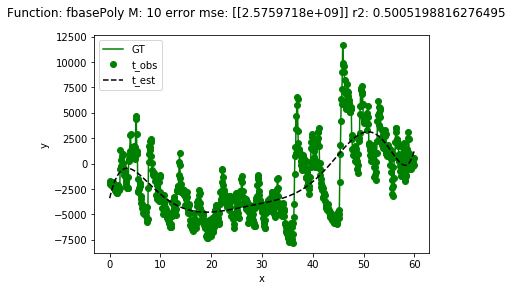

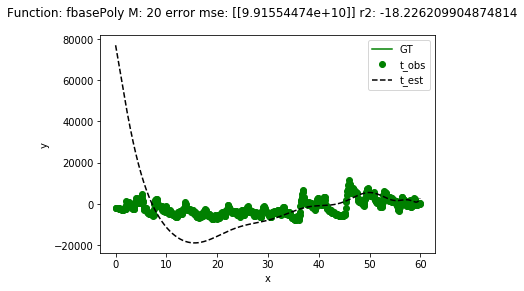

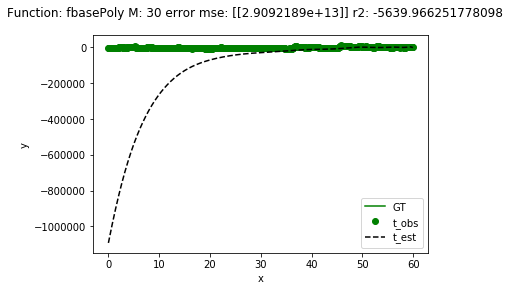

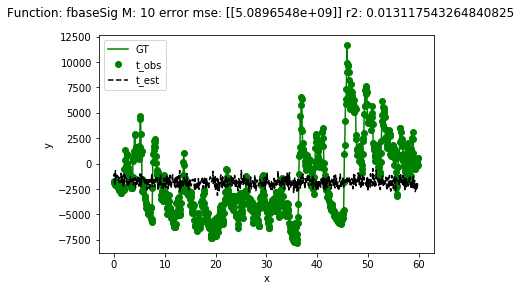

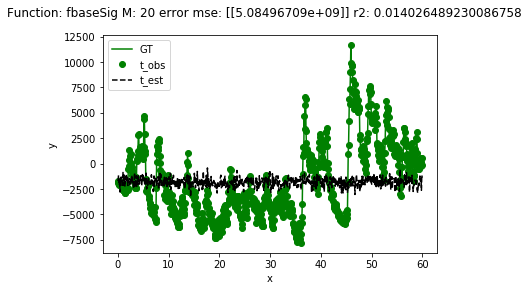

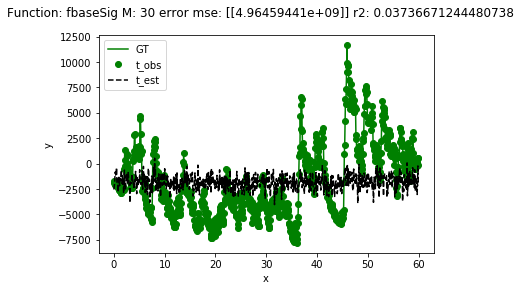

In [110]:
N = 816
M = [10, 20, 30] # Número de funciones base
F = [fbaseExp, fbasePoly, fbaseSig]
cont = 1
plt.figure(1)
columns = ["Función", "# F base", "E mse", "r2"]
infoMVResp = pd.DataFrame(columns = columns)
t_real = t_obs
t_obs = t_real
for f in F:
    for m in M:
        infoRow = []
        infoRow.append(f.__name__)
        infoRow.append(m)
        MPHI, w_ml = obtenerModelo(x, m, f)
        yEst, error_mse, r2 = estimarModeloConsumo(x, t_real, t_obs, MPHI, w_ml, cont, f.__name__, m, True)
        infoRow.append(error_mse)
        infoRow.append(r2)
        graficar(x, t_real, t_obs, MPHI, yEst, f.__name__, M, [error_mse], r2, 'og')
        infoMVResp.loc[cont] = infoRow
        cont += 1
print("Modelo de máxima verosimilitud")
result = infoMVResp.sort_values('r2', ascending=0)
result = result.style.apply(highlight_greaterthan_1, axis=1)
printSdMean(infoMVResp, F)
result

## Máxima verosimilitud con regularización $\lambda$ - respiration.mat

Modelo de máxima verosimilitud con regularizacion, consumodb
fbaseExp
Promedio
lambda    0.100005
r2        0.000215
dtype: float64
Desviación estandar
lambda    0.109539
r2        0.000170
dtype: float64
----------------------------------------
fbasePoly
Promedio
lambda       0.100005
r2       -6472.970718
dtype: float64
Desviación estandar
lambda        0.109539
r2        13386.851204
dtype: float64
----------------------------------------
fbaseSig
Promedio
lambda    0.100005
r2        0.015960
dtype: float64
Desviación estandar
lambda    0.109539
r2        0.015104
dtype: float64
----------------------------------------


<Figure size 432x288 with 0 Axes>

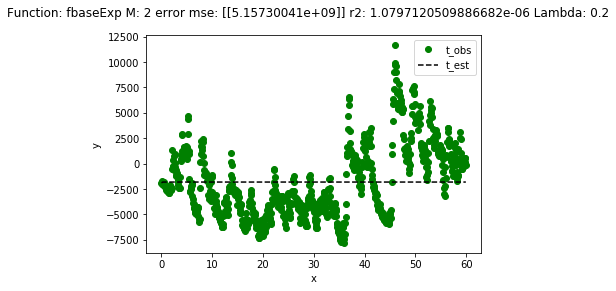

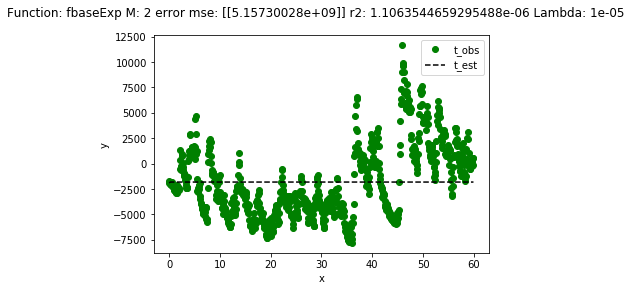

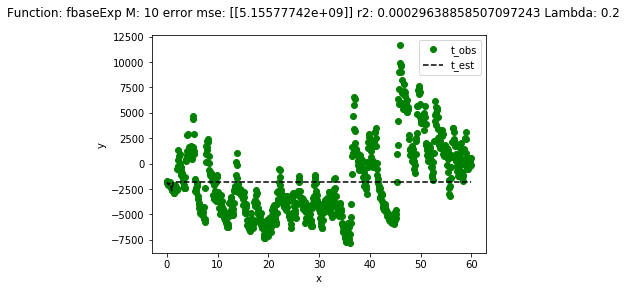

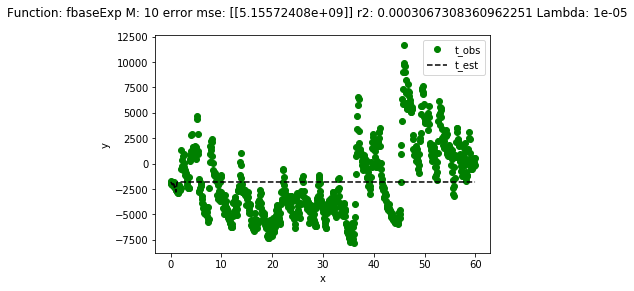

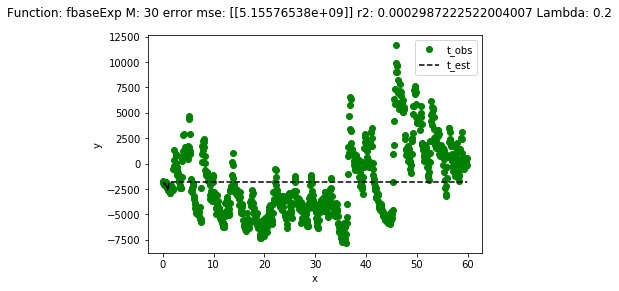

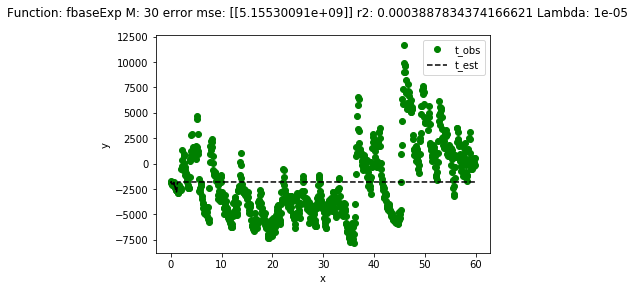

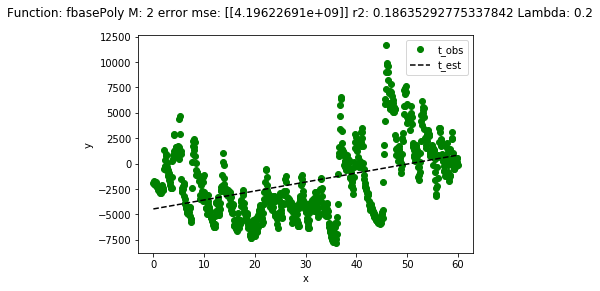

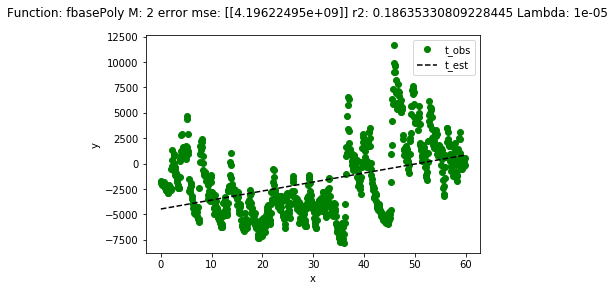

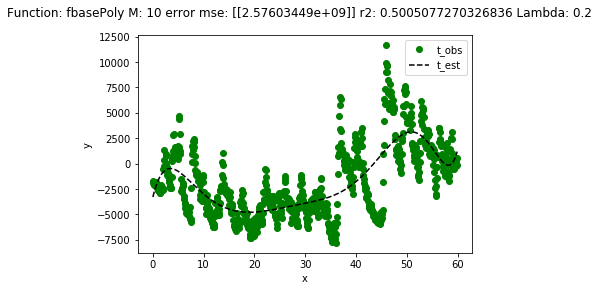

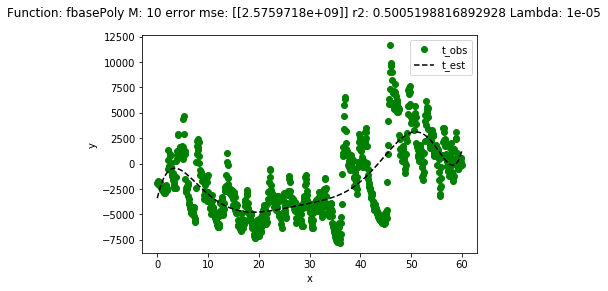

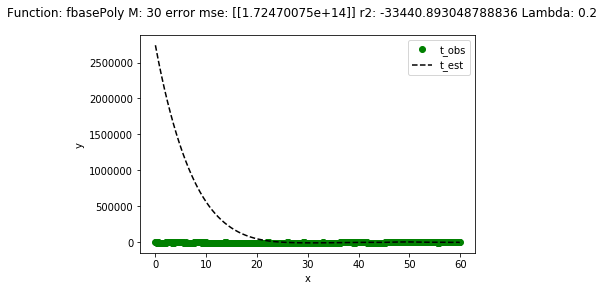

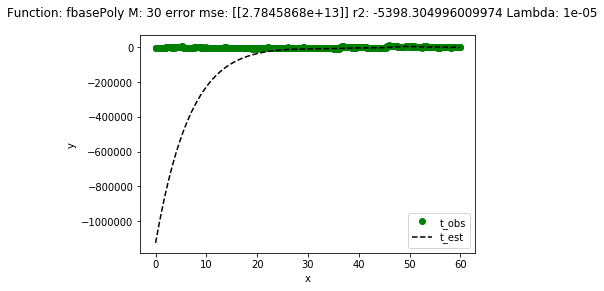

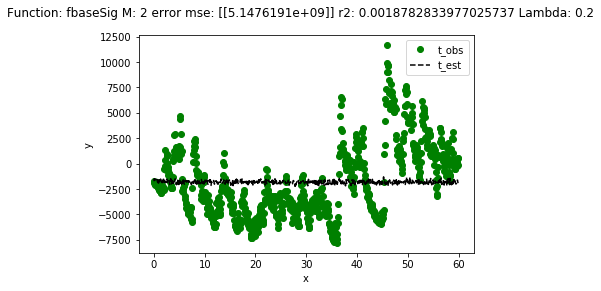

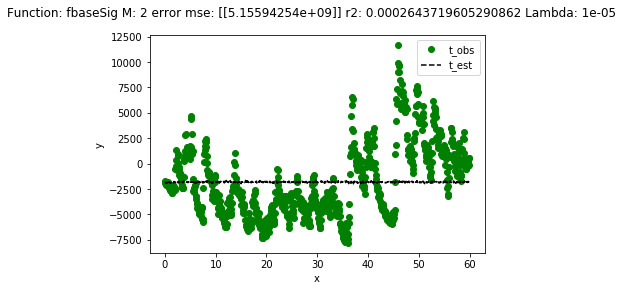

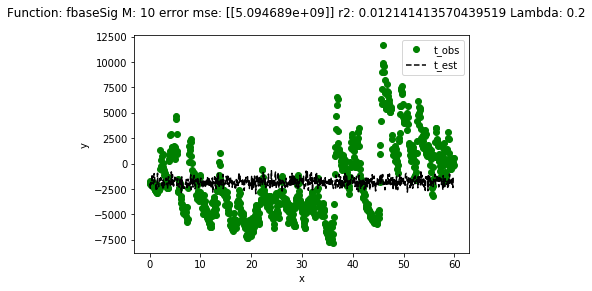

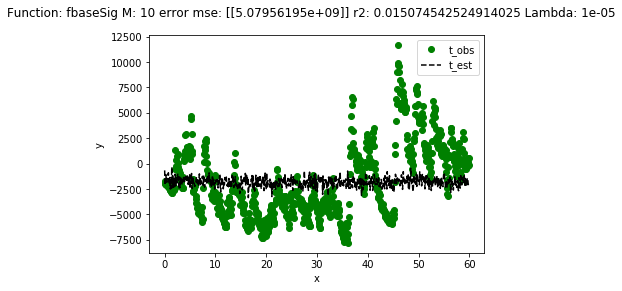

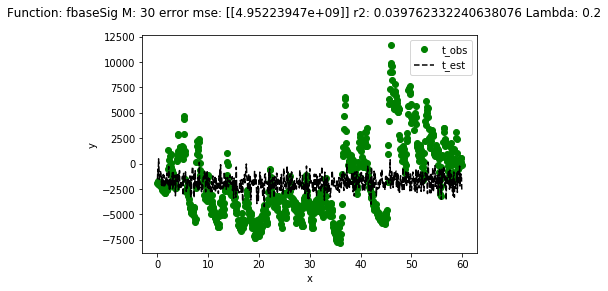

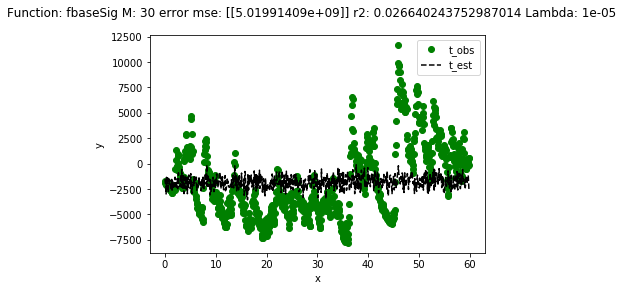

In [111]:
N = 816
M = [2, 10, 30] # Número de funciones base
F = [fbaseExp, fbasePoly, fbaseSig]
cont = 1
plt.figure(1)
columns = ["Función", "# F base", "lambda", "E mse", "r2"]
infoMVrespReg = pd.DataFrame(columns = columns)
lambdas = [0.2, 0.00001]
for f in F:
    for m in M:
        for l in lambdas:
            infoRow = []
            infoRow.append(f.__name__)
            infoRow.append(m)
            infoRow.append(l)
            MPHI, w_ml = obtenerModeloRegulado(x, m, f, l)
            yEst, error_mse, r2 = estimarModeloConsumo(x, t_real, t_obs, MPHI, w_ml, cont, f.__name__, m, True)
            infoRow.append(error_mse)
            infoRow.append(r2)
            graficarConsumoReg(x, t_real, t_obs, MPHI, yEst, f.__name__, M, [error_mse], r2, l, 'og')
            infoMVrespReg.loc[cont] = infoRow
            cont += 1
print("Modelo de máxima verosimilitud con regularizacion, consumodb")
result = infoMVrespReg.sort_values('r2', ascending=0)
result = result.style.apply(highlight_greaterthan_1, axis=1)
printSdMean(infoMVrespReg, F)
result

## Regresión lineal bayesiana - respiration.mat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(

fbaseExp
Promedio
Error bayes                            (5158419140.5961275+0j)
alpha           (7.999350520693838e-07-3.514611854759883e-42j)
beta           (7.886488147701713e-08+1.1099734475580654e-45j)
dtype: complex128
Desviación estandar
Error bayes    2.244522e+06
alpha          2.505693e-07
beta           7.602255e-11
dtype: float64
----------------------------------------
fbasePoly
Promedio
Error bayes        (7259252787073.652+0j)
alpha              (6.215557462829599+0j)
beta           (9.844041684311533e-08+0j)
dtype: complex128
Desviación estandar
Error bayes    1.256878e+13
alpha          1.076440e+01
beta           8.523710e-08
dtype: float64
----------------------------------------
fbaseSig
Promedio
Error bayes        (5092092175.813229+0j)
alpha          (1.158515387569472e-05+0j)
beta           (7.928692868198629e-08+0j)
dtype: complex128
Desviación estandar
Error bayes    2.834046e+07
alpha          1.246423e-05
beta           1.908997e-10
dtype: float64
-----------

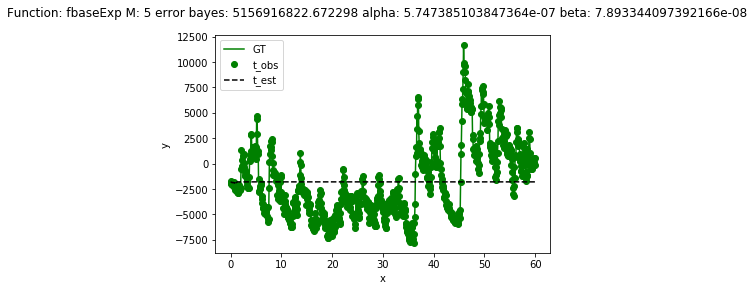

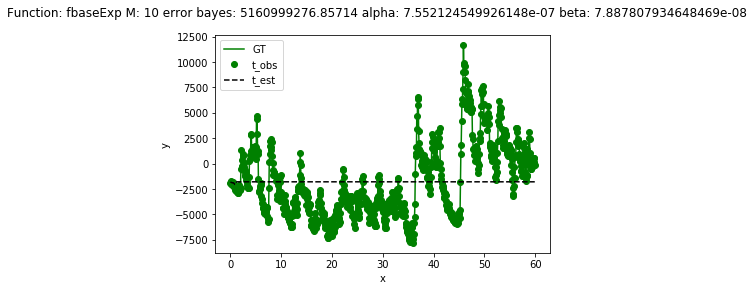

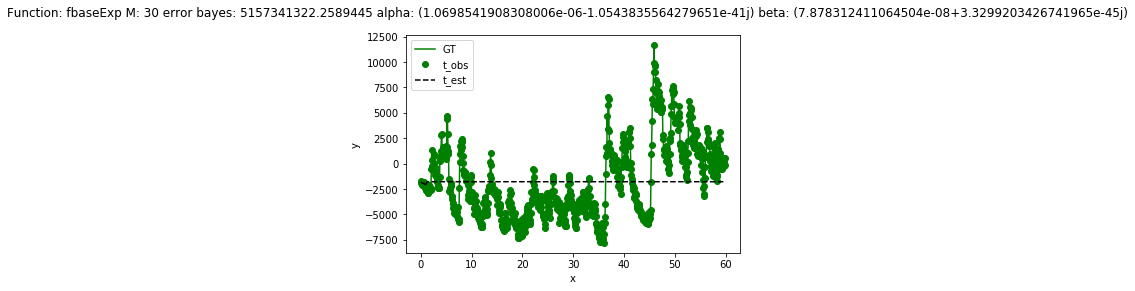

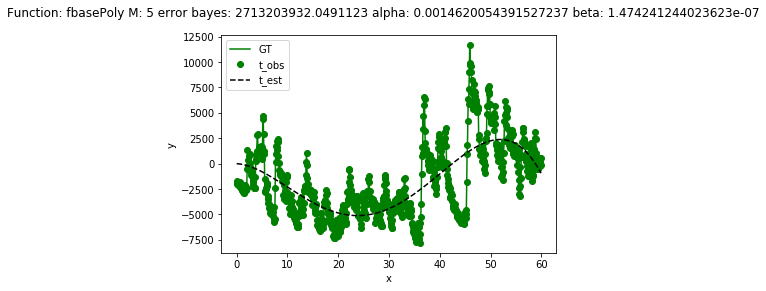

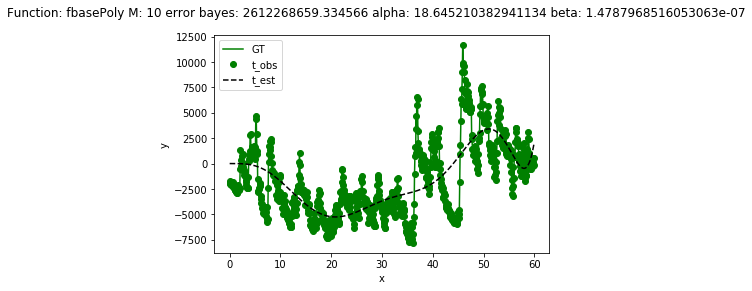

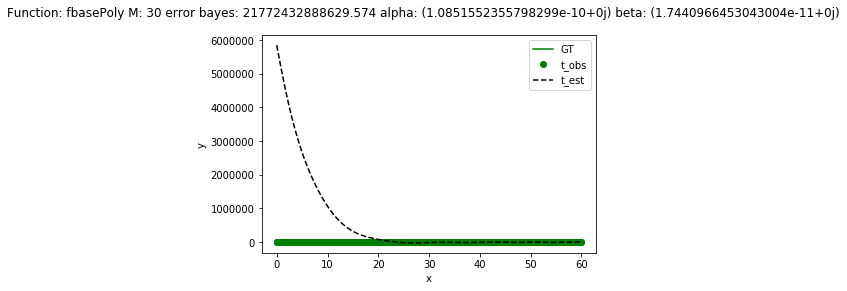

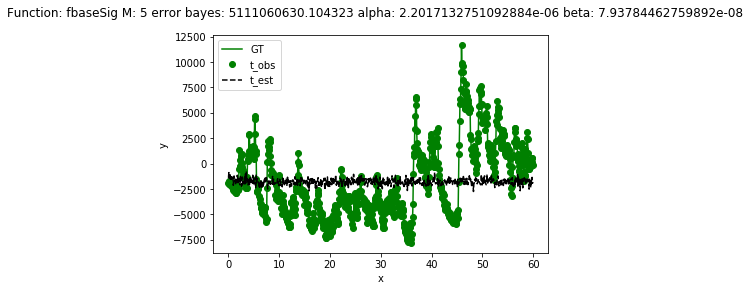

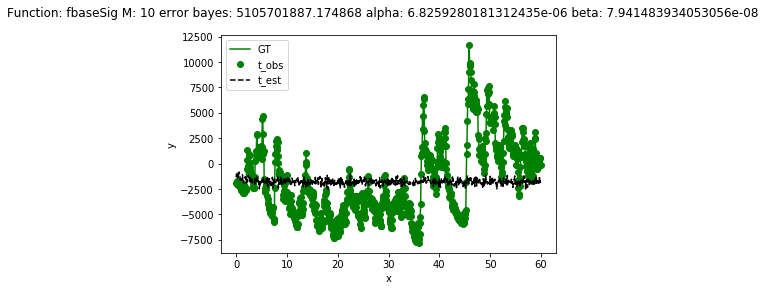

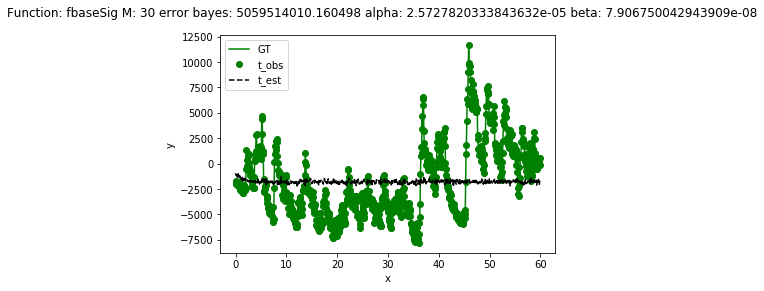

In [112]:
x = x.reshape(816,)
t_obs = t_obs.reshape(816,)
columns = ["Función", "# F base", "Error bayes", "alpha", "beta"]
infoBYRespiracion = pd.DataFrame(columns = columns)
M = [5, 10, 30] # Número de funciones base
a = 0
b = 0
for f in F:
    for m in M:
        infoRow = []
        infoRow.append(f.__name__)
        infoRow.append(m)
        MPHI, mn, error_bayes, a, b = obtenerModeloBayesiano(x, m, f, 30)
        yEst, error_mse, r2 = estimarModelo(x, t_real, t_obs, MPHI, mn, cont, f.__name__, m, getr2=False)
        infoRow.append(error_bayes[0])
        infoRow.append(a)
        infoRow.append(b)
        # infoRow.append(r2)
        graficarBayes(x, t_real, t_obs, MPHI, yEst, f.__name__, M, error_bayes, a, b, 'og')
        infoBYRespiracion.loc[cont] = infoRow
        cont += 1

result = infoBYRespiracion.sort_values('Error bayes', ascending=0)
result = result.style.apply(highlight_bayes, axis=1)
printSdMean(infoBYRespiracion, F)
result

# Plethysmograph

## Upload

In [113]:
! wget https://github.com/mhdelta/machineLearningUtp/blob/master/data/Plethysmograph.mat?raw=true
!mv Plethysmograph.mat\?raw\=true Plethysmograph.mat

--2019-09-05 15:29:01--  https://github.com/mhdelta/machineLearningUtp/blob/master/data/Plethysmograph.mat?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mhdelta/machineLearningUtp/raw/master/data/Plethysmograph.mat [following]
--2019-09-05 15:29:01--  https://github.com/mhdelta/machineLearningUtp/raw/master/data/Plethysmograph.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhdelta/machineLearningUtp/master/data/Plethysmograph.mat [following]
--2019-09-05 15:29:02--  https://raw.githubusercontent.com/mhdelta/machineLearningUtp/master/data/Plethysmograph.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercon

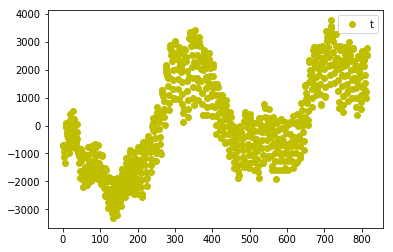

In [114]:
mat = scipy.io.loadmat("Plethysmograph.mat")
t_obs = mat["t"].reshape((816,))
x = mat["x"]
n = 5
plt.plot(t_obs, "oy")
plt.legend(("t_obs"))
x = x.reshape((816,))

## Máxima verosimilitud plethysmograph


Modelo de máxima verosimilitud
fbaseExp
Promedio
E mse    1.061830e+09
r2       5.848618e-03
dtype: float64
Desviación estandar
E mse    228594.099263
r2            0.000214
dtype: float64
----------------------------------------
fbasePoly
Promedio
E mse    1.550325e+09
r2      -4.515109e-01
dtype: float64
Desviación estandar
E mse    2.694610e+09
r2       2.522862e+00
dtype: float64
----------------------------------------
fbaseSig
Promedio
E mse    1.049709e+09
r2       1.719665e-02
dtype: float64
Desviación estandar
E mse    4.572371e+06
r2       4.280939e-03
dtype: float64
----------------------------------------


<Figure size 432x288 with 0 Axes>

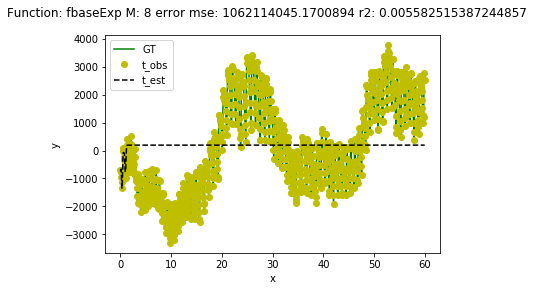

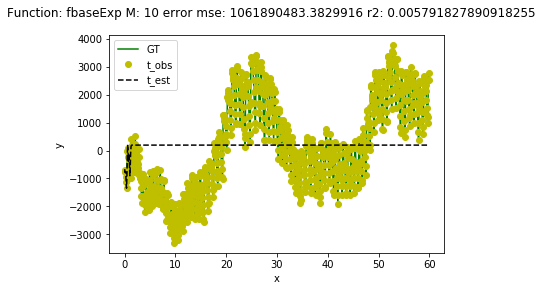

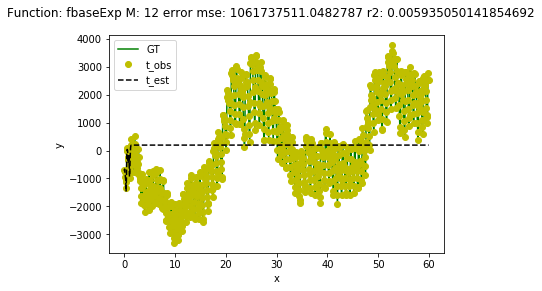

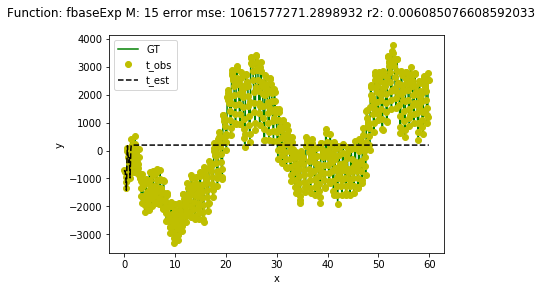

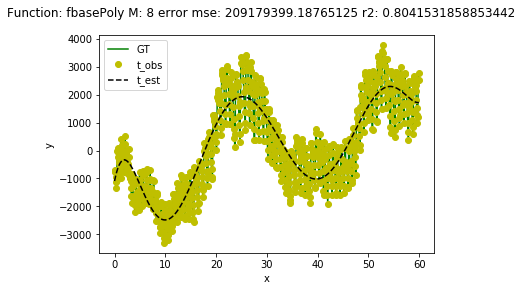

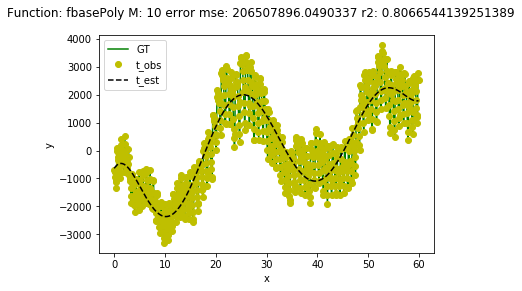

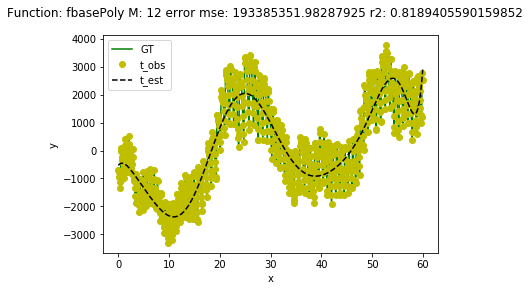

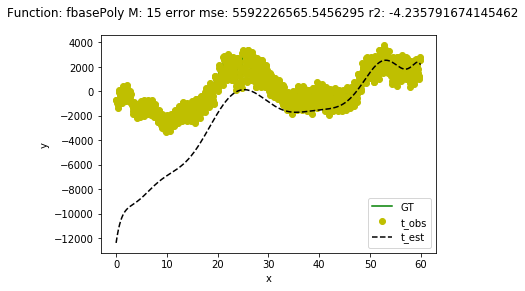

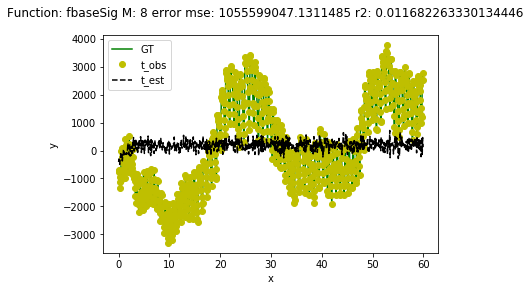

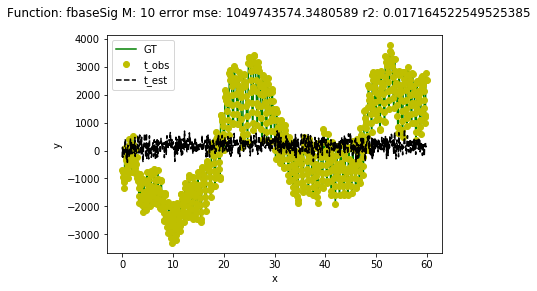

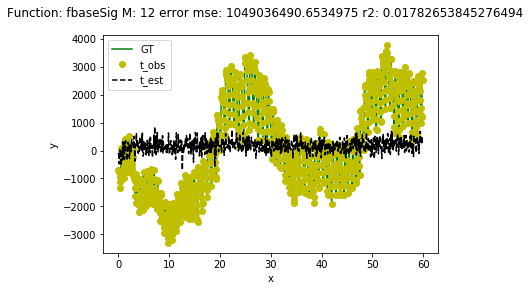

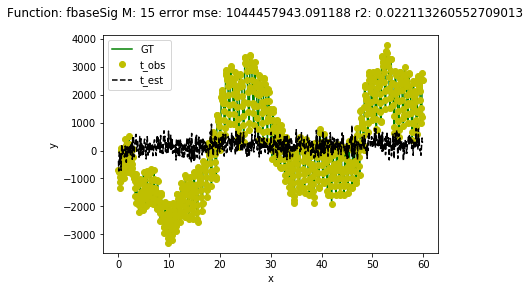

In [115]:
N = 816
M = [8, 10, 12, 15] # Número de funciones base
F = [fbaseExp, fbasePoly, fbaseSig]
cont = 1
plt.figure(1)
columns = ["Función", "# F base", "E mse", "r2"]
infoMVPlet = pd.DataFrame(columns = columns)
t_real = t_obs
t_obs = t_real
for f in F:
    for m in M:
        infoRow = []
        infoRow.append(f.__name__)
        infoRow.append(m)
        MPHI, w_ml = obtenerModelo(x, m, f)
        yEst, error_mse, r2 = estimarModeloConsumo(x, t_real, t_obs, MPHI, w_ml, cont, f.__name__, m, True)
        infoRow.append(error_mse)
        infoRow.append(r2)
        graficar(x, t_real, t_obs, MPHI, yEst, f.__name__, M, [error_mse], r2, 'oy')
        infoMVPlet.loc[cont] = infoRow
        cont += 1
print("Modelo de máxima verosimilitud")
result = infoMVPlet.sort_values('r2', ascending=0)
result = result.style.apply(highlight_greaterthan_1, axis=1)
printSdMean(infoMVPlet, F)
result

## Máxima verosimilitud con regularización $\lambda$ - Plethysmograph

Modelo de máxima verosimilitud con regularizacion, consumodb
fbaseExp
Promedio
lambda    1.000050e-01
E mse     1.063514e+09
r2        4.272119e-03
dtype: float64
Desviación estandar
lambda    1.095390e-01
E mse     2.633210e+06
r2        2.465376e-03
dtype: float64
----------------------------------------
fbasePoly
Promedio
lambda    1.000050e-01
E mse     5.342543e+13
r2       -5.001923e+04
dtype: float64
Desviación estandar
lambda    1.095390e-01
E mse     1.116864e+14
r2        1.045678e+05
dtype: float64
----------------------------------------
fbaseSig
Promedio
lambda    1.000050e-01
E mse     1.049620e+09
r2        1.728025e-02
dtype: float64
Desviación estandar
lambda    1.095390e-01
E mse     1.597679e+07
r2        1.495847e-02
dtype: float64
----------------------------------------


<Figure size 432x288 with 0 Axes>

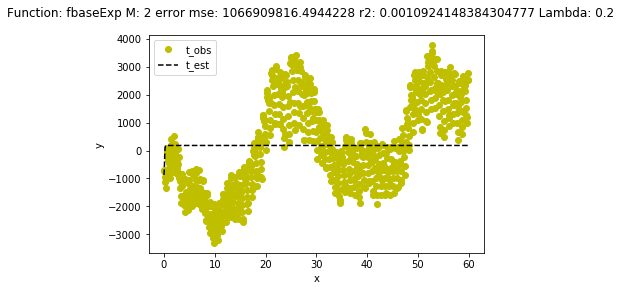

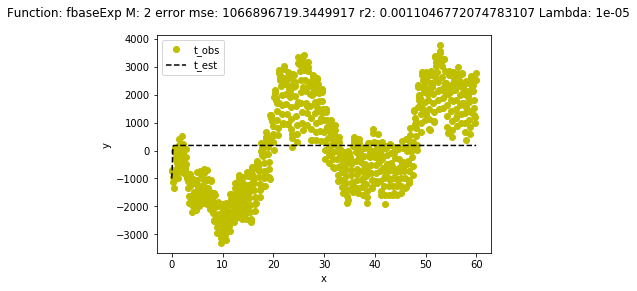

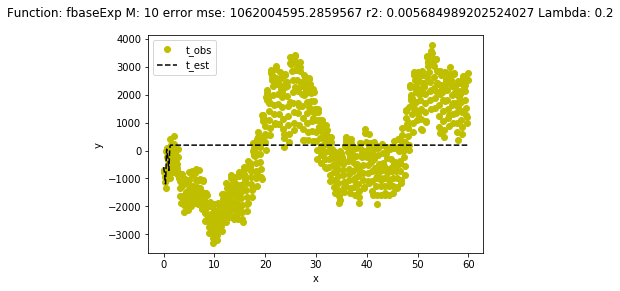

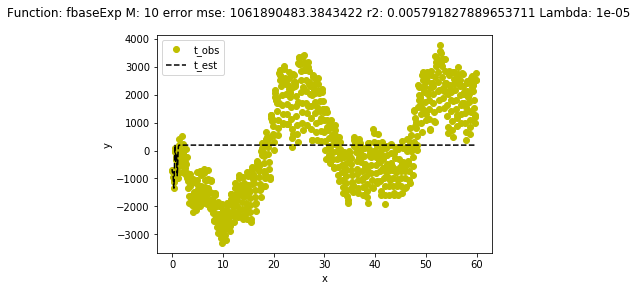

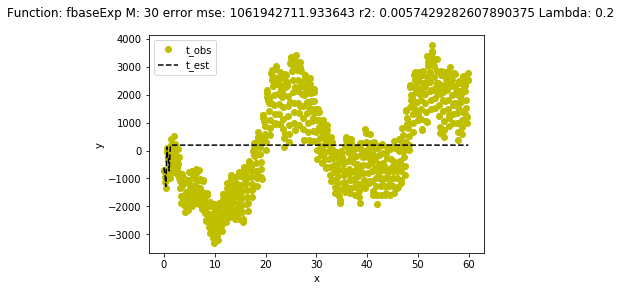

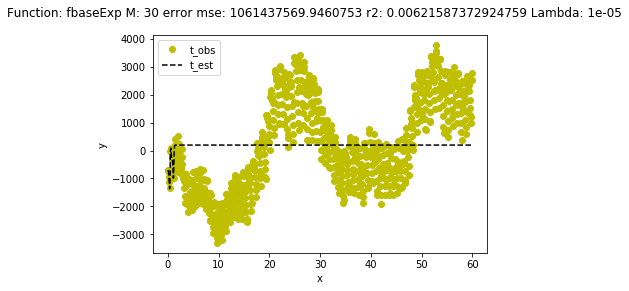

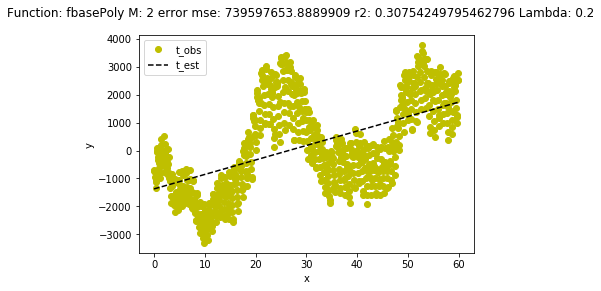

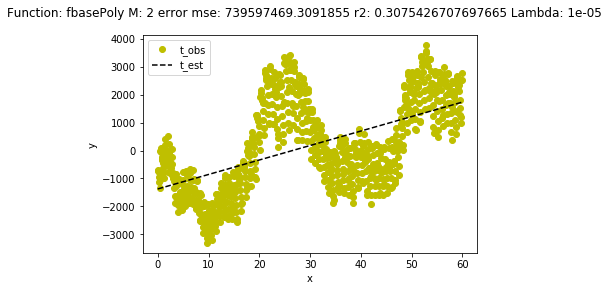

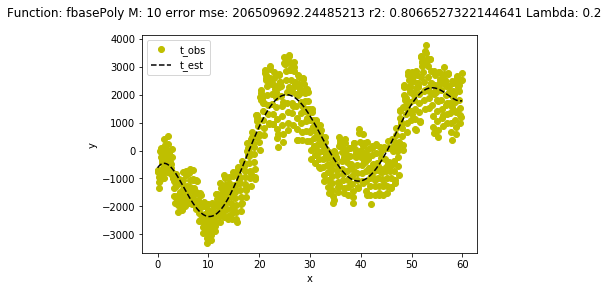

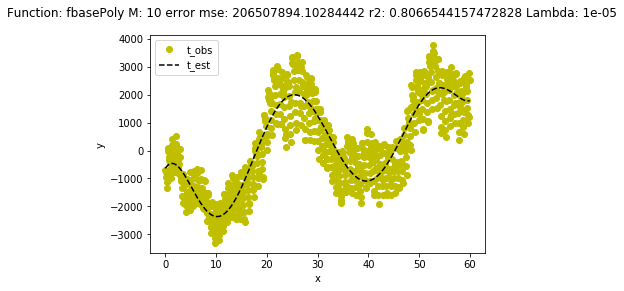

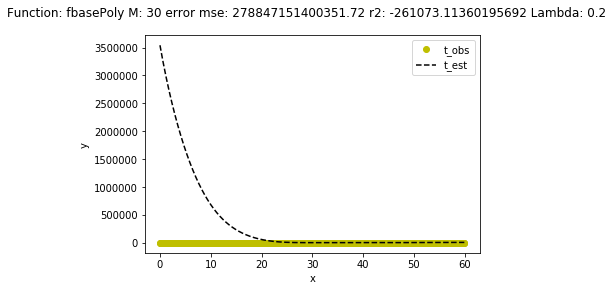

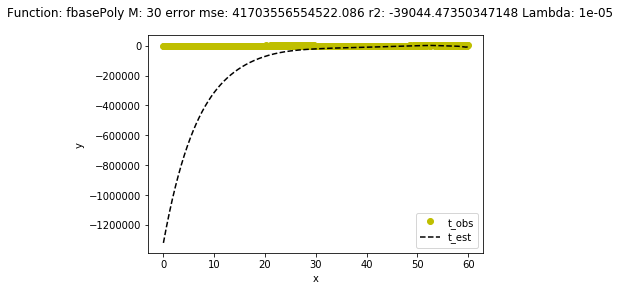

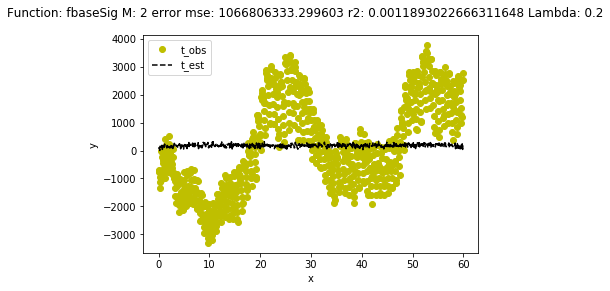

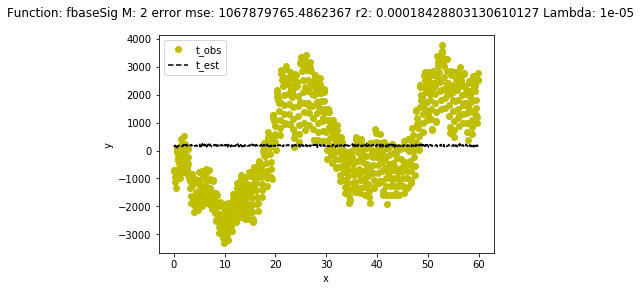

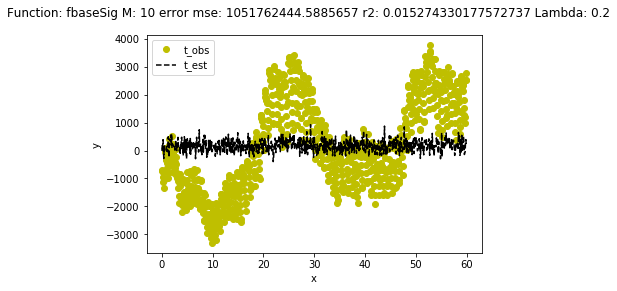

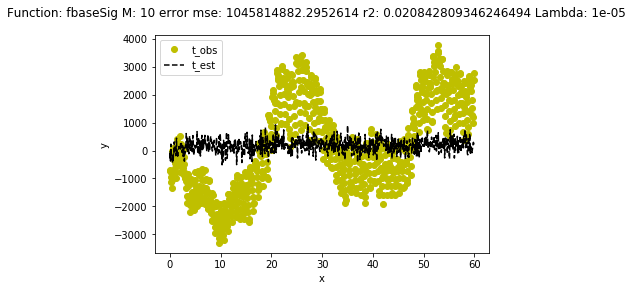

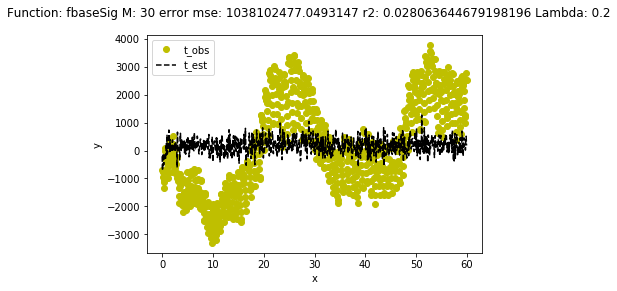

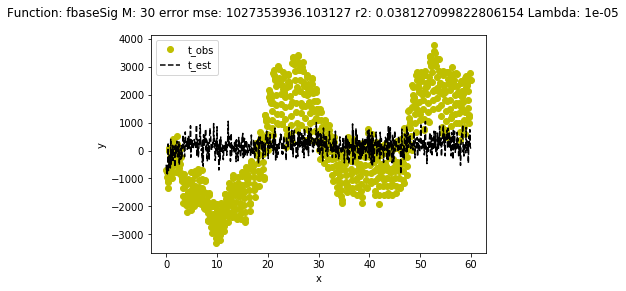

In [116]:
N = 816
M = [2, 10, 30] # Número de funciones base
F = [fbaseExp, fbasePoly, fbaseSig]
cont = 1
plt.figure(1)
columns = ["Función", "# F base", "lambda", "E mse", "r2"]
infoMVPletReg = pd.DataFrame(columns = columns)
lambdas = [0.2, 0.00001]
for f in F:
    for m in M:
        for l in lambdas:
            infoRow = []
            infoRow.append(f.__name__)
            infoRow.append(m)
            infoRow.append(l)
            MPHI, w_ml = obtenerModeloRegulado(x, m, f, l)
            yEst, error_mse, r2 = estimarModeloConsumo(x, t_real, t_obs, MPHI, w_ml, cont, f.__name__, m, True)
            infoRow.append(error_mse)
            infoRow.append(r2)
            graficarConsumoReg(x, t_real, t_obs, MPHI, yEst, f.__name__, M, [error_mse], r2, l, 'oy')
            infoMVPletReg.loc[cont] = infoRow
            cont += 1
print("Modelo de máxima verosimilitud con regularizacion, consumodb")
result = infoMVPletReg.sort_values('r2', ascending=0)
result = result.style.apply(highlight_greaterthan_1, axis=1)
printSdMean(infoMVPletReg, F)
result

## Regresion lineal bayesiana - Plethysmograph

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid v

fbaseExp
Promedio
Error bayes                            (1079886858.0707679+0j)
alpha             (3.497574503138e-05-1.3145369822373157e-39j)
beta           (3.816822394594736e-07+2.5309715227897365e-44j)
dtype: complex128
Desviación estandar
Error bayes    2.411336e+07
alpha          1.511265e-06
beta           1.145224e-10
dtype: float64
----------------------------------------
fbasePoly
Promedio
Error bayes        (3182637735703088+0j)
alpha          (0.001263761693798445+0j)
beta           (8.64831018674635e-07+0j)
dtype: complex128
Desviación estandar
Error bayes    5.512490e+15
alpha          2.177124e-03
beta           9.740382e-07
dtype: float64
----------------------------------------
fbaseSig
Promedio
Error bayes         (93252962244.16635+0j)
alpha           (0.0006253508789056676+0j)
beta           (3.8216830294122695e-07+0j)
dtype: complex128
Desviación estandar
Error bayes    1.596814e+11
alpha          6.315030e-04
beta           3.336433e-10
dtype: float64
-----------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


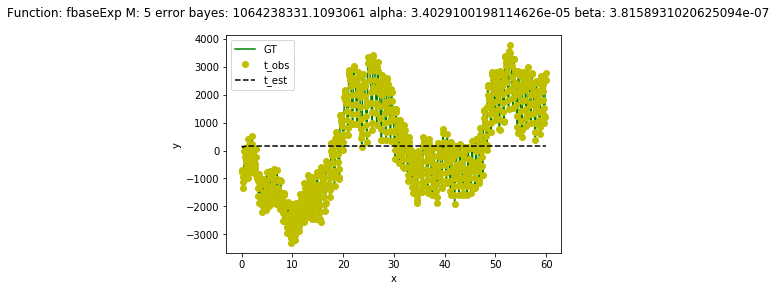

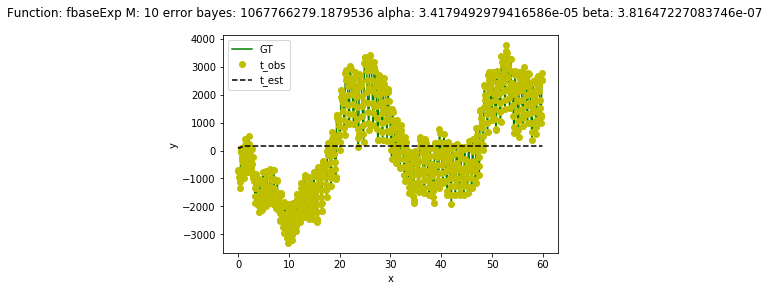

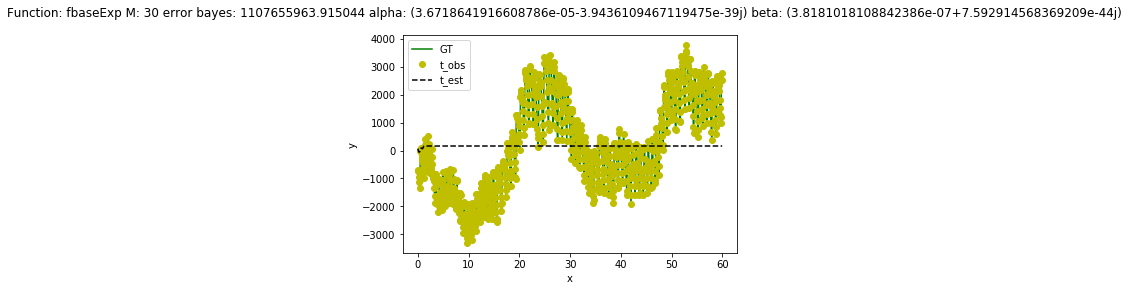

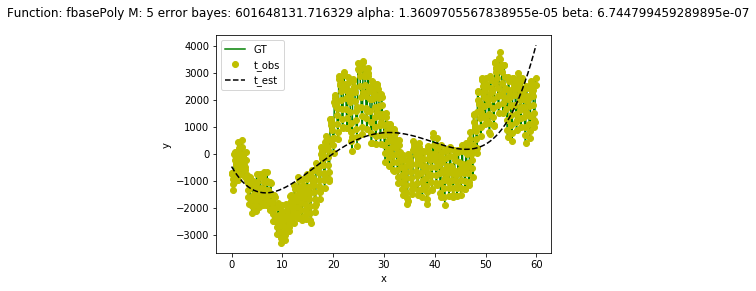

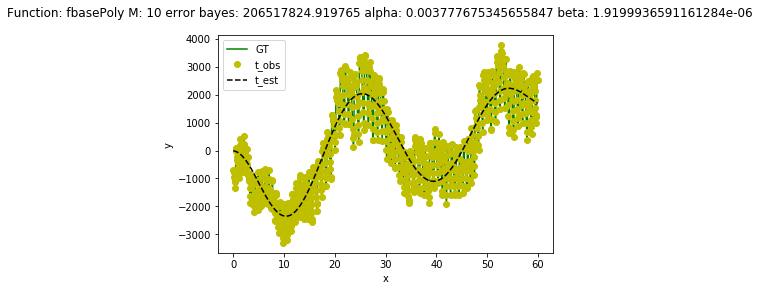

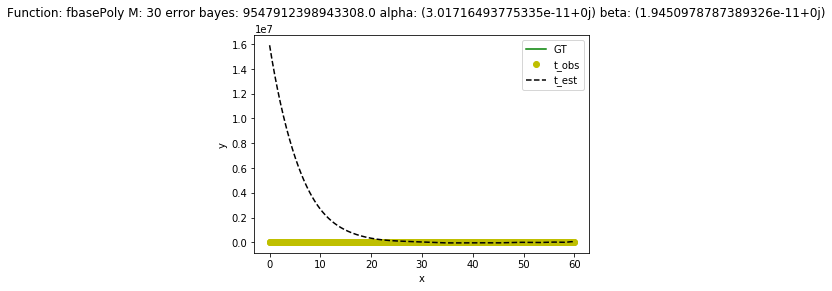

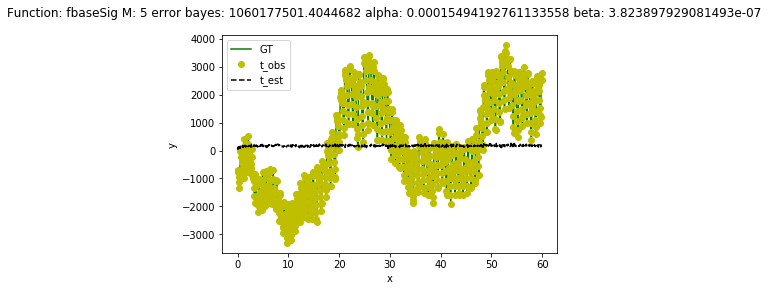

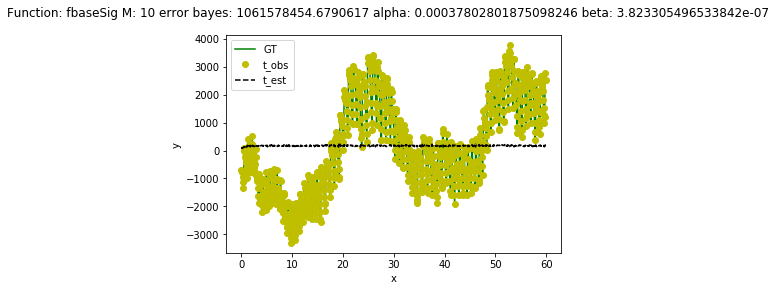

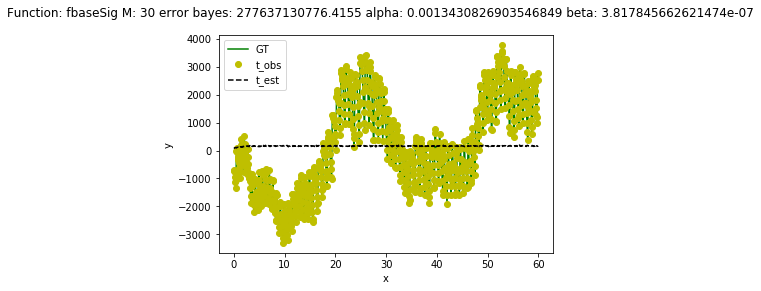

In [117]:
x = x.reshape(816,)
t_obs = t_obs.reshape(816,)
columns = ["Función", "# F base", "Error bayes", "alpha", "beta"]
infoBYPlet = pd.DataFrame(columns = columns)
M = [5, 10, 30] # Número de funciones base
a = 0
b = 0
for f in F:
    for m in M:
        infoRow = []
        infoRow.append(f.__name__)
        infoRow.append(m)
        MPHI, mn, error_bayes, a, b = obtenerModeloBayesiano(x, m, f, 30)
        yEst, error_mse, r2 = estimarModelo(x, t_real, t_obs, MPHI, mn, cont, f.__name__, m, getr2=False)
        infoRow.append(error_bayes[0])
        infoRow.append(a)
        infoRow.append(b)
        # infoRow.append(r2)
        graficarBayes(x, t_real, t_obs, MPHI, yEst, f.__name__, M, error_bayes, a, b, 'oy')
        infoBYPlet.loc[cont] = infoRow
        cont += 1

result = infoBYPlet.sort_values('Error bayes', ascending=0)
result = result.style.apply(highlight_bayes, axis=1)
printSdMean(infoBYPlet, F)
result